- Chat: https://chatgpt.com/share/6736edd3-6104-800e-8648-0ce4e4240d29
- Source data: http://td.winnerstudio.vip:8996/#/tga/ide/59_32514

C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\1457421184.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_games_data['Treatment'] = top_games_data['nth_game'].apply(


,game,Treatment,day_7_net_amount_sum
0,102: com.asselin.android.fortunelegends,New user,382.405218
1,102: com.asselin.android.fortunelegends,Recycled user,287.162060
2,102: com.asselin.android.luckylegends,New user,39.136792
3,102: com.asselin.android.luckylegends,Recycled user,45.126049
4,102: com.prudentprophet.jackpotspinning777,New user,106.955124
5,102: com.prudentprophet.jackpotspinning777,Recycled user,141.600783
6,102: com.shrewdscholar.mirthvegas,New user,117.945674
7,102: com.shrewdscholar.mirthvegas,Recycled user,128.149601
8,59: com.reelsflight.newb,New user,70.789090
9,59: com.reelsflight.newb,Recycled user,73.442359


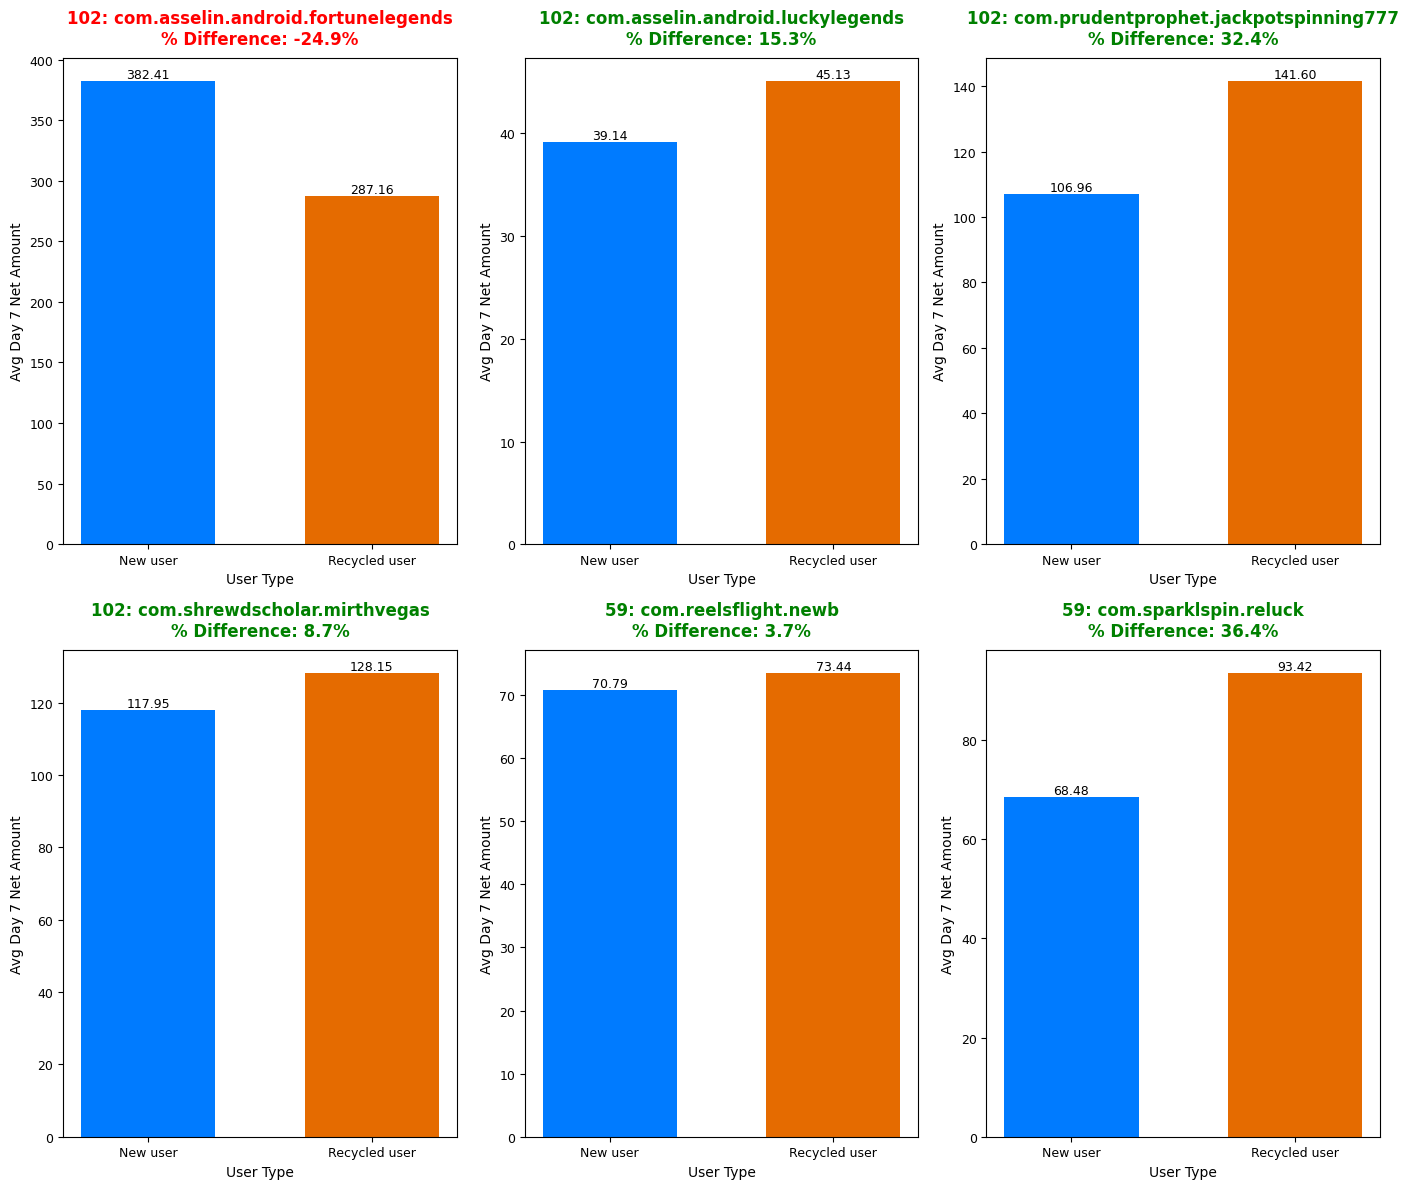

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
# https://chatgpt.com/share/6736edd3-6104-800e-8648-0ce4e4240d29

# Function to display DataFrame in Jupyter Notebook
def display_dataframe_to_user(name, dataframe):
    """
    Display a DataFrame in a user-friendly HTML format in Jupyter notebooks.
    
    Args:
        name (str): Title for the displayed DataFrame.
        dataframe (pd.DataFrame): The DataFrame to display.
    """
    style = """
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
            margin-bottom: 1em;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
            font-weight: bold;
        }
    </style>
    """
    display(HTML(f"{style}<h3>{name}</h3>"))
    display(dataframe)

# Load your dataset
file_path = 'C:/Users/Win11/Downloads/20241115_060823_50567_v56n5.csv' #http://td.winnerstudio.vip:8996/#/tga/ide/59_32514
data = pd.read_csv(file_path)

# Data Processing
# 1. Filter for users with day_7_net_amount_sum > 0
filtered_data = data[data['day_7_net_amount_sum'] > 0]

# 2. Identify the top 6 games with the greatest number of users
top_games = (
    filtered_data['game']
    .value_counts()
    .head(6)
    .index
)

# 3. Filter the dataset to include only these top games
top_games_data = filtered_data[filtered_data['game'].isin(top_games)]

# 4. Add a 'Treatment' column based on nth_game
top_games_data['Treatment'] = top_games_data['nth_game'].apply(
    lambda x: 'Recycled user' if x > 1 else 'New user'
)

# 5. Calculate the average day_7_net_amount_sum for each game and treatment
grouped_data = (
    top_games_data.groupby(['game', 'Treatment'])
    .agg({'day_7_net_amount_sum': 'mean'})
    .reset_index()
)

# 6. Ensure games are sorted by their occurrence count for consistency
grouped_data['game'] = pd.Categorical(
    grouped_data['game'],
    categories=top_games,
    ordered=True
)

# Display the grouped DataFrame
display_dataframe_to_user(name="Grouped Data for Visualization", dataframe=grouped_data)

# Visualization
unique_games = grouped_data['game'].unique()
num_games = len(unique_games)
cols = int(np.ceil(np.sqrt(num_games)))  # Number of columns for a square-like layout
rows = int(np.ceil(num_games / cols))   # Rows based on the number of columns

plt.figure(figsize=(14, 12))

for i, game in enumerate(unique_games, start=1):
    subset = grouped_data[grouped_data['game'] == game]
    
    # Extract New user and Recycled user values
    new_user_value = subset[subset['Treatment'] == 'New user']['day_7_net_amount_sum'].values[0]
    recycled_user_value = subset[subset['Treatment'] == 'Recycled user']['day_7_net_amount_sum'].values[0]
    
    # Calculate percentage difference
    percentage_diff = ((recycled_user_value - new_user_value) / new_user_value) * 100
    
    # Set up subplot
    plt.subplot(rows, cols, i)
    bars = plt.bar(subset['Treatment'], subset['day_7_net_amount_sum'], color=['#007bff', '#e56b00'], width=0.6)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Title with percentage difference
    diff_color = 'green' if percentage_diff > 0 else 'red'
    plt.title(
        f'{game}\n% Difference: {percentage_diff:.1f}%', 
        fontsize=12, weight='bold', pad=10, color=diff_color
    )
    
    # Axes labels
    plt.xlabel('User Type', fontsize=10)
    plt.ylabel('Avg Day 7 Net Amount', fontsize=10)
    
    # Format ticks
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.grid(False)

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [2]:
import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script, bs_token, host):
    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 2000,
        'sql':            sql_script
    }
    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)
    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]
    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis = 1)
    return data

# Function to display DataFrame in Jupyter Notebook
def display_dataframe_to_user(name, dataframe):
    """
    Display a DataFrame in a user-friendly HTML format in Jupyter notebooks.
    
    Args:
        name (str): Title for the displayed DataFrame.
        dataframe (pd.DataFrame): The DataFrame to display.
    """
    style = """
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
            margin-bottom: 1em;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
            font-weight: bold;
        }
    </style>
    """
    display(HTML(f"{style}<h3>{name}</h3>"))
    display(dataframe)


In [4]:
final_query = f"""
with acorn_all as (
SELECT 
  game,
  users."#account_id",
  email,
  "register_time",

  -- Net amounts
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 1 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d1_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 3 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d3_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 7 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d7_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 14 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d14_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 30 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d30_net_amount_sum,

  COUNT(DISTINCT IF(DATE_DIFF('day', "register_time", "#event_time") <= 1, 1, NULL)) AS d1_freq,
  COUNT(IF(DATE_DIFF('day', "register_time", "#event_time") <= 3, 1, NULL))          AS d3_freq,
  COUNT(IF(DATE_DIFF('day', "register_time", "#event_time") <= 7, 1, NULL))          AS d7_freq,
  COUNT(IF(DATE_DIFF('day', "register_time", "#event_time") <= 14, 1, NULL))         AS d14_freq,
  COUNT(IF(DATE_DIFF('day', "register_time", "#event_time") <= 30, 1, NULL))         AS d30_freq,

  -- Withdrawn amounts
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 1 AND "$part_event" = 'withdraw_success', 
         CAST("amount" AS DOUBLE) - CAST("withdraw_fee" AS DOUBLE), 0.0)) AS d1_withdrawn_amount,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 3 AND "$part_event" = 'withdraw_success', 
         CAST("amount" AS DOUBLE) - CAST("withdraw_fee" AS DOUBLE), 0.0)) AS d3_withdrawn_amount,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 7 AND "$part_event" = 'withdraw_success', 
         CAST("amount" AS DOUBLE) - CAST("withdraw_fee" AS DOUBLE), 0.0)) AS d7_withdrawn_amount,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 14 AND "$part_event" = 'withdraw_success', 
         CAST("amount" AS DOUBLE) - CAST("withdraw_fee" AS DOUBLE), 0.0)) AS d14_withdrawn_amount,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 30 AND "$part_event" = 'withdraw_success', 
         CAST("amount" AS DOUBLE) - CAST("withdraw_fee" AS DOUBLE), 0.0)) AS d30_withdrawn_amount,

  -- Money won amounts
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 1 AND "$part_event" = 'game_play' AND machine_type = 1 AND (bet_money > 0 OR bet_bonus > 0), 
         CAST("win_amount" AS DOUBLE), 0.0)) AS d1_money_won,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 3 AND "$part_event" = 'game_play' AND machine_type = 1 AND (bet_money > 0 OR bet_bonus > 0), 
         CAST("win_amount" AS DOUBLE), 0.0)) AS d3_money_won,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 7 AND "$part_event" = 'game_play' AND machine_type = 1 AND (bet_money > 0 OR bet_bonus > 0), 
         CAST("win_amount" AS DOUBLE), 0.0)) AS d7_money_won,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 14 AND "$part_event" = 'game_play' AND machine_type = 1 AND (bet_money > 0 OR bet_bonus > 0), 
         CAST("win_amount" AS DOUBLE), 0.0)) AS d14_money_won,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 30 AND "$part_event" = 'game_play' AND machine_type = 1 AND (bet_money > 0 OR bet_bonus > 0), 
         CAST("win_amount" AS DOUBLE), 0.0)) AS d30_money_won,

  -- Money bet amounts
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 1 AND "$part_event" = 'game_play' AND machine_type = 1, 
         CAST(bet_money AS DOUBLE) + CAST(bet_bonus AS DOUBLE), 0.0)) AS d1_money_bet,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 3 AND "$part_event" = 'game_play' AND machine_type = 1, 
         CAST(bet_money AS DOUBLE) + CAST(bet_bonus AS DOUBLE), 0.0)) AS d3_money_bet,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 7 AND "$part_event" = 'game_play' AND machine_type = 1, 
         CAST(bet_money AS DOUBLE) + CAST(bet_bonus AS DOUBLE), 0.0)) AS d7_money_bet,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 14 AND "$part_event" = 'game_play' AND machine_type = 1, 
         CAST(bet_money AS DOUBLE) + CAST(bet_bonus AS DOUBLE), 0.0)) AS d14_money_bet,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 30 AND "$part_event" = 'game_play' AND machine_type = 1, 
         CAST(bet_money AS DOUBLE) + CAST(bet_bonus AS DOUBLE), 0.0)) AS d30_money_bet

FROM
  (SELECT 
      "#account_id", 
      "#event_time", 
      "net_amount", 
      "amount", 
      "withdraw_fee", 
      "$part_event",
      "bet_money",
      "bet_bonus",
      "win_amount",
      "machine_type"
   FROM 
      ta.v_event_102
   WHERE 
      "$part_event" IN ('order_pay', 'withdraw_success', 'game_play') 
      AND "$part_date" BETWEEN '2024-06-03' AND '2024-10-13'
  ) AS p
RIGHT JOIN
  (SELECT 
      email, 
      "#account_id", 
      "register_time", 
      CONCAT('102: ', bundle_id) AS game
   FROM 
      ta.v_user_102
   WHERE 
      CAST("register_time" AS VARCHAR) BETWEEN '2024-06-03' AND '2024-10-13'
  ) AS users
ON 
  p."#account_id" = users."#account_id"
GROUP BY 
  1, 2, 3, 4
)

, output_aux as (
select *,rank() over (partition by email order by "register_time") as nth_game
from acorn_all
where email is not null)

select *
from output_aux
where nth_game <= 5
and d30_freq > 0
"""

print(final_query)


with acorn_all as (
SELECT 
  game,
  users."#account_id",
  email,
  "register_time",

  -- Net amounts
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 1 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d1_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 3 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d3_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 7 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d7_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 14 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d14_net_amount_sum,
  SUM(IF(DATE_DIFF('day', "register_time", "#event_time") <= 30 AND "$part_event" = 'order_pay', 
         CAST("net_amount" AS DOUBLE), 0.0)) AS d30_net_amount_sum,

  COUNT(DISTINCT IF(DATE_DIFF('day', "register_time", "#event_time") 

In [5]:
df = pull_data(final_query, bs_token, host)
df.sample(2)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


,#account_id,d14_freq,d14_money_bet,d14_money_won,d14_net_amount_sum,d14_withdrawn_amount,d1_freq,d1_money_bet,d1_money_won,d1_net_amount_sum,...,d3_withdrawn_amount,d7_freq,d7_money_bet,d7_money_won,d7_net_amount_sum,d7_withdrawn_amount,email,game,nth_game,register_time
89786,60008174,7,0.7,0.46,0.0,0.0,1,0.7,0.46,0.0,...,0.0,7,0.7,0.46,0.0,0.0,Anthony928792@gmail.com,102: com.prudentowl.lavishluck,1,2024-10-04 05:54:47.000
256707,40726811,4,0.4,0.16,0.0,0.0,1,0.4,0.16,0.0,...,0.0,4,0.4,0.16,0.0,0.0,Beardking1123@icloud.com,102: com.prudentprophet.jackpotspinning777,1,2024-08-25 21:10:51.000


In [26]:
# Re-executing the corrected computation for withdraw ratios

time_intervals = ['d1', 'd3', 'd7', 'd14', 'd30']

for interval in time_intervals:
    net_column = f'{interval}_net_amount_sum'
    withdrawn_column = f'{interval}_withdrawn_amount'
    ratio_column = f'{interval}_withdraw_ratio'
    df[ratio_column] = df.apply(
        lambda row: row[withdrawn_column] / row[net_column] if row[net_column] != 0 else None,
        axis=1)



In [39]:
# Obtain the withdraw ratio
df.groupby(['game', 'nth_game']).size().reset_index(drop=False).to_csv('n_sizes.csv')

In [27]:
time_columns = [
    'd1_net_amount_sum',
    'd3_net_amount_sum',
    'd7_net_amount_sum',
    'd14_net_amount_sum',
    'd30_net_amount_sum'
]

top_12_games = (
    df['game']
    .value_counts()
    .head(12)
    .index
)

In [28]:
# Filter the dataset to include only these top games
top_games_data = df[df['game'].isin(top_12_games)]

# Add a 'Treatment' column based on nth_game
top_games_data['Treatment'] = top_games_data['nth_game'].apply(
    lambda x: 'Recycled user' if x > 1 else 'New user'
)

# Calculate the average for all time-based columns, grouped by game and treatment
grouped_data = (
    top_games_data.groupby(['game', 'Treatment'])[time_columns]
    .mean()
    .reset_index()
)

# Ensure games are sorted by their occurrence count for consistency
grouped_data['game'] = pd.Categorical(
    grouped_data['game'],
    categories=top_12_games,
    ordered=True
)


C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\704432381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_games_data['Treatment'] = top_games_data['nth_game'].apply(


I think this is what should be done

,game,Treatment,d1_net_amount_sum,d3_net_amount_sum,d7_net_amount_sum,d14_net_amount_sum,d30_net_amount_sum
0,102: com.asselin.android.fortunelegends,New user,3.382277,5.343639,9.173718,14.758727,23.356752
1,102: com.asselin.android.fortunelegends,Recycled user,3.502533,6.133124,10.480205,18.786387,30.562471
2,102: com.asselin.android.jackpotlegends,New user,3.641234,5.926740,10.435011,16.695362,26.335605
3,102: com.asselin.android.jackpotlegends,Recycled user,4.352649,7.399227,13.792699,22.785639,36.910882
4,102: com.asselin.android.luckylegends,New user,2.863932,4.513663,7.832311,12.770589,22.060596
5,102: com.asselin.android.luckylegends,Recycled user,3.686384,6.725206,12.479158,20.073620,30.821454
6,102: com.asselin.android.wildlegends,New user,3.065375,4.776759,7.951837,13.089110,21.694211
7,102: com.asselin.android.wildlegends,Recycled user,3.981749,7.146383,13.168933,23.386587,37.263041
8,102: com.asselin.samsung.luckylegends,New user,4.956473,7.836332,13.309142,23.271844,42.632725
9,102: com.asselin.samsung.luckylegends,Recycled user,5.281766,7.652350,11.827240,19.950926,30.788831


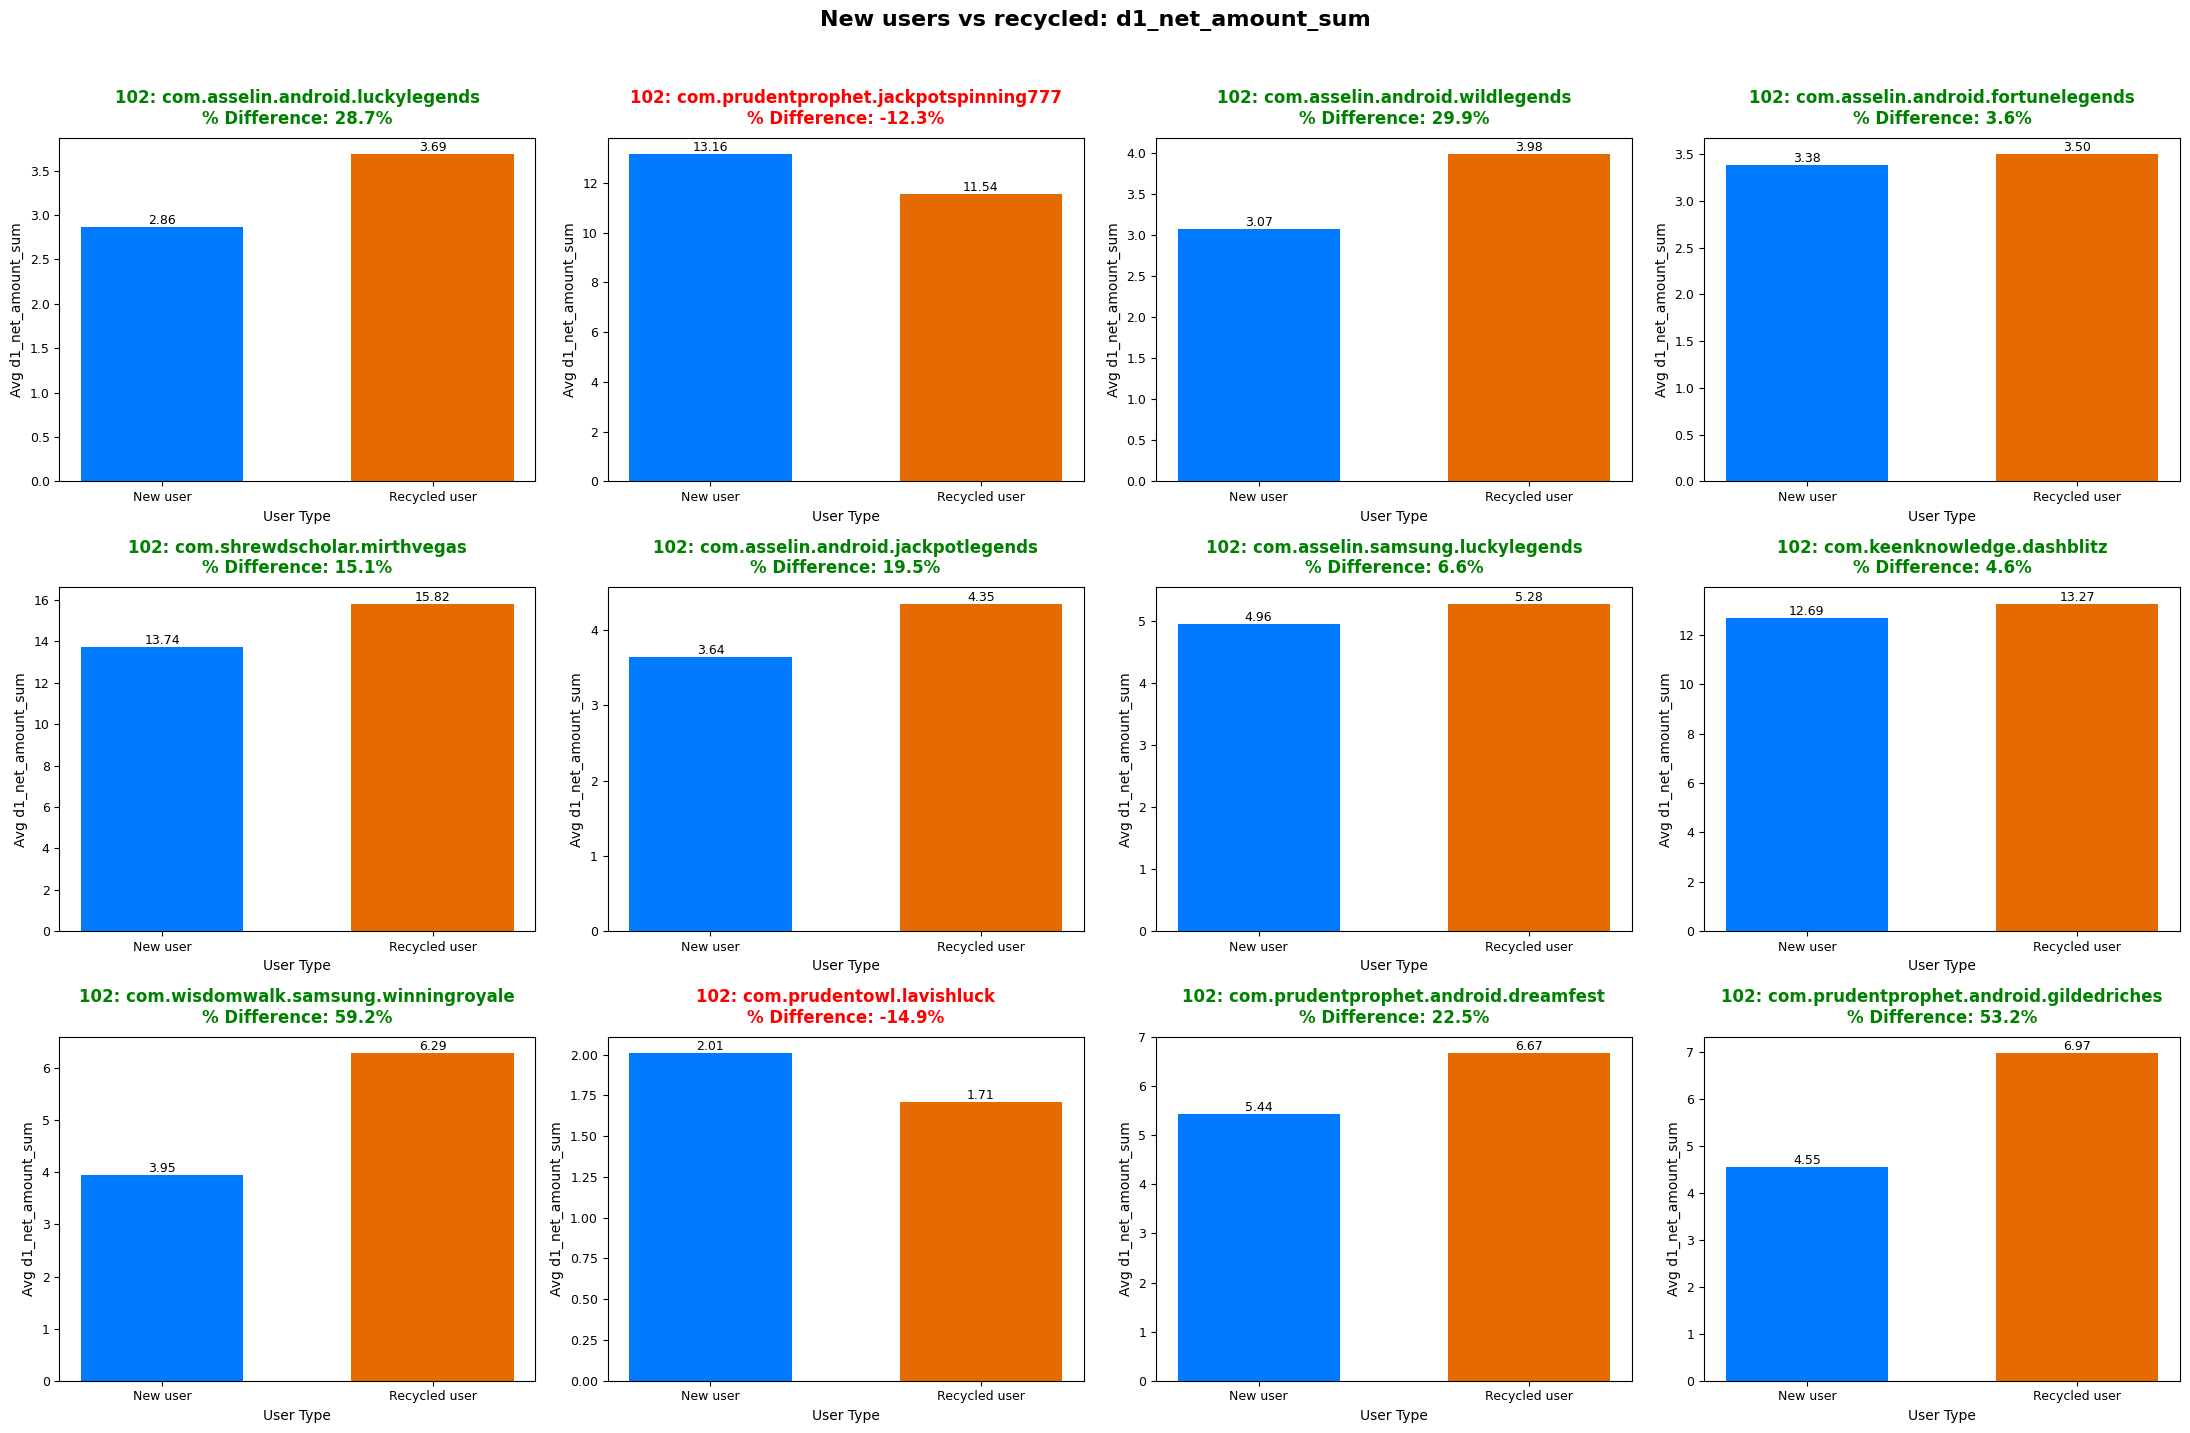

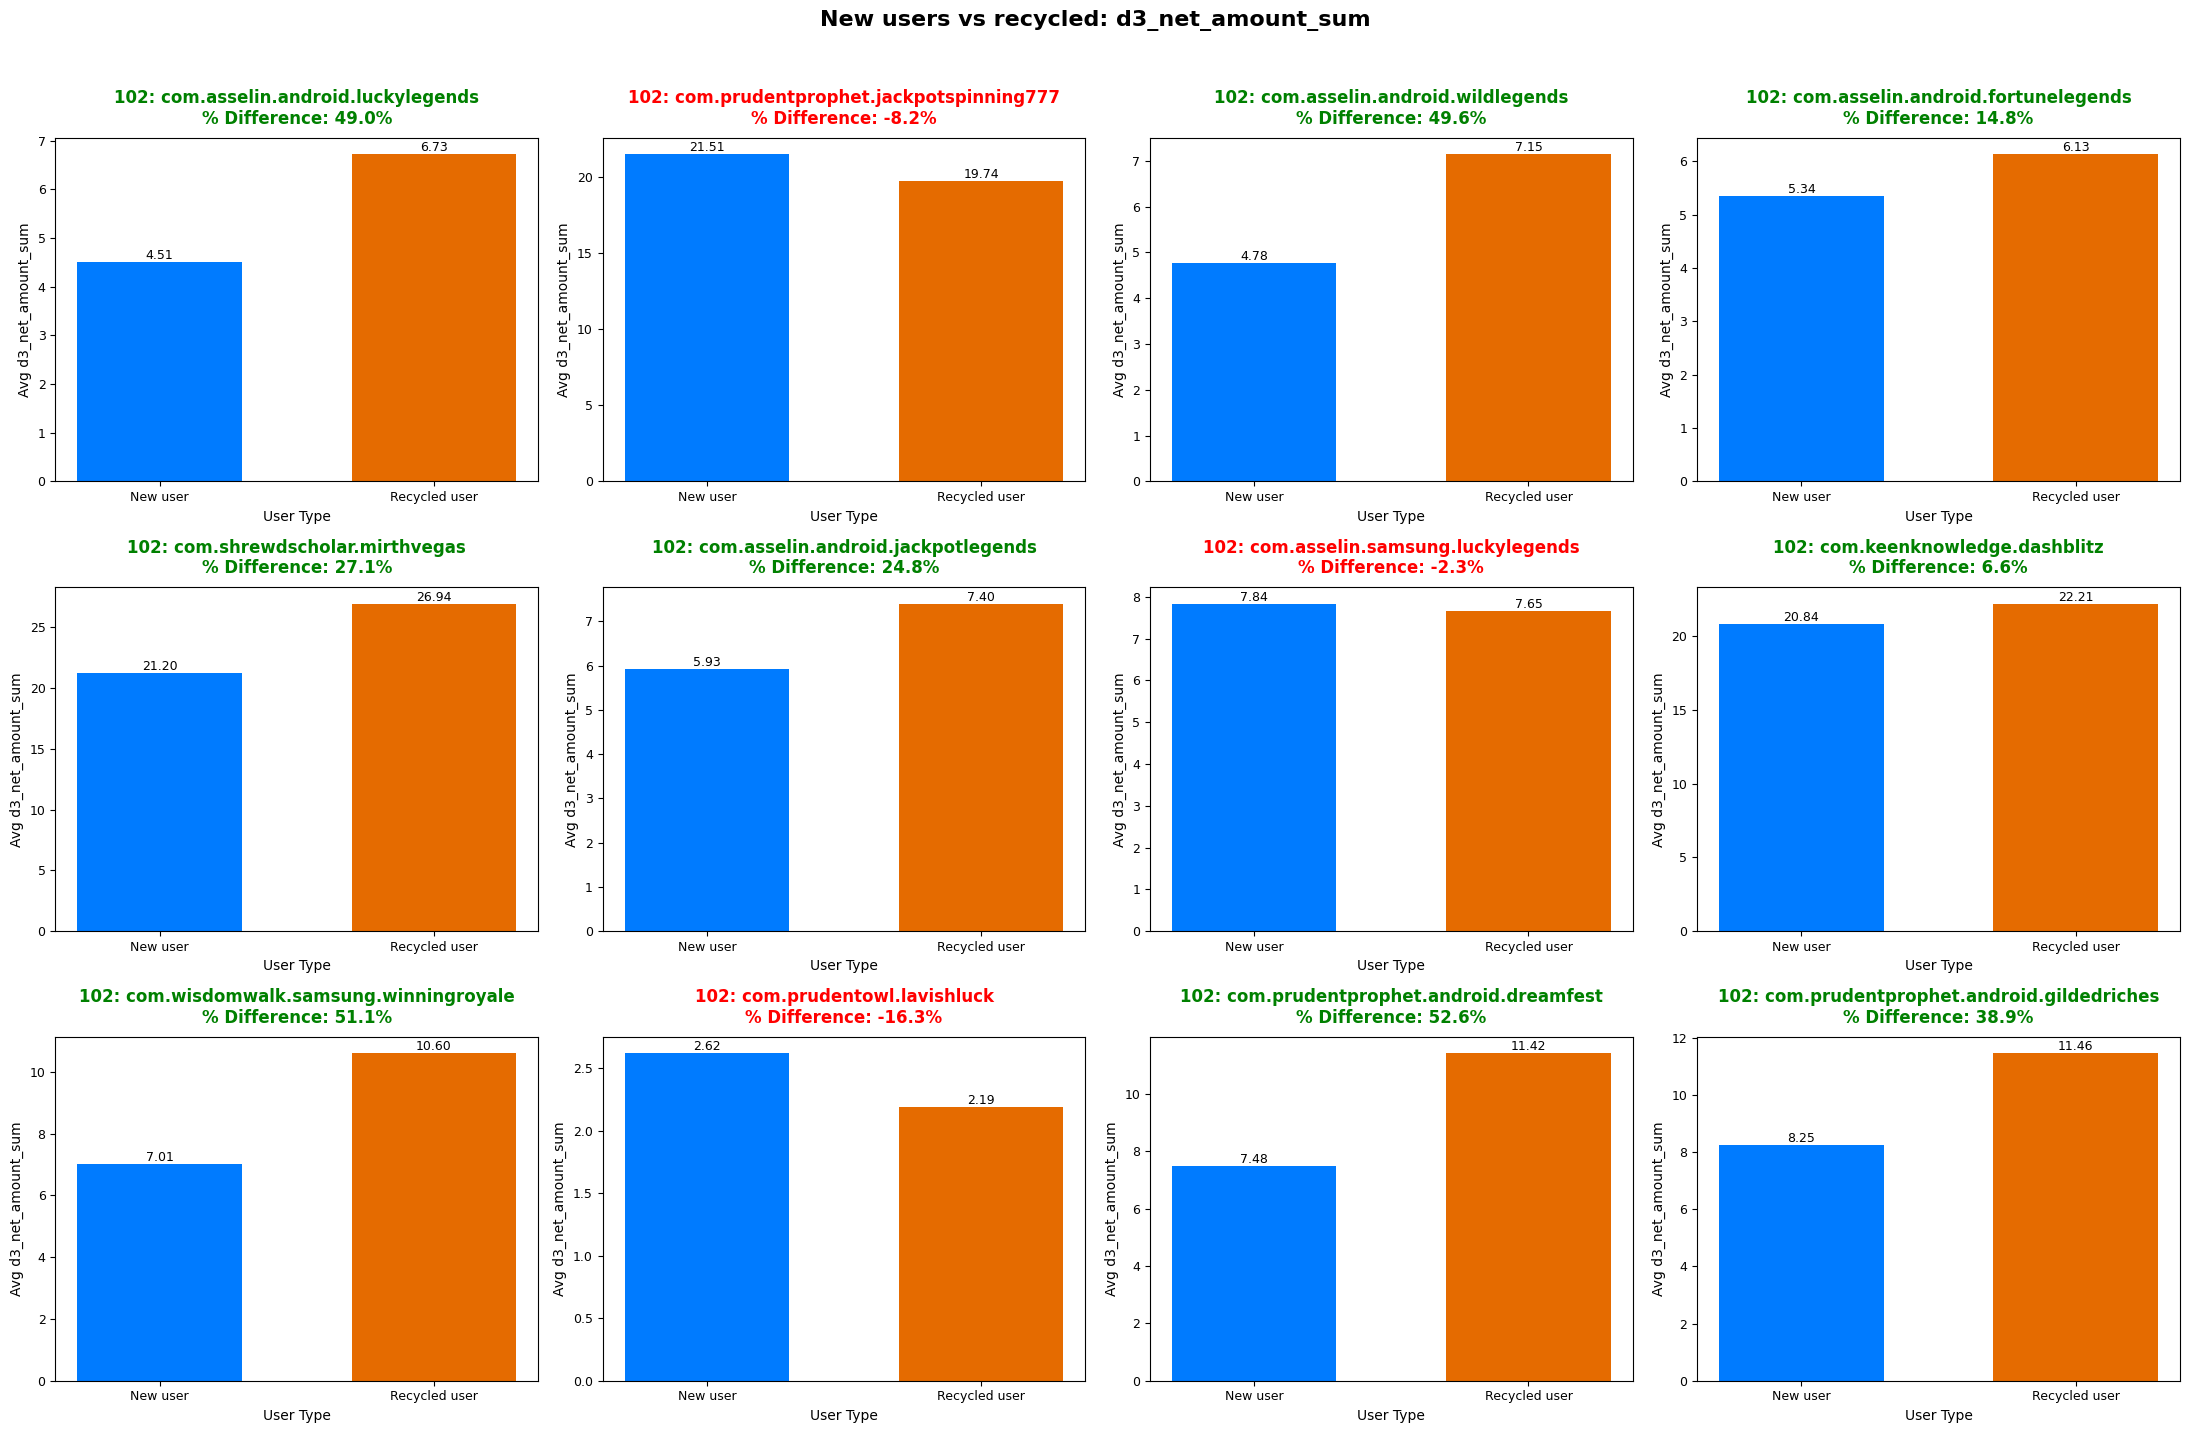

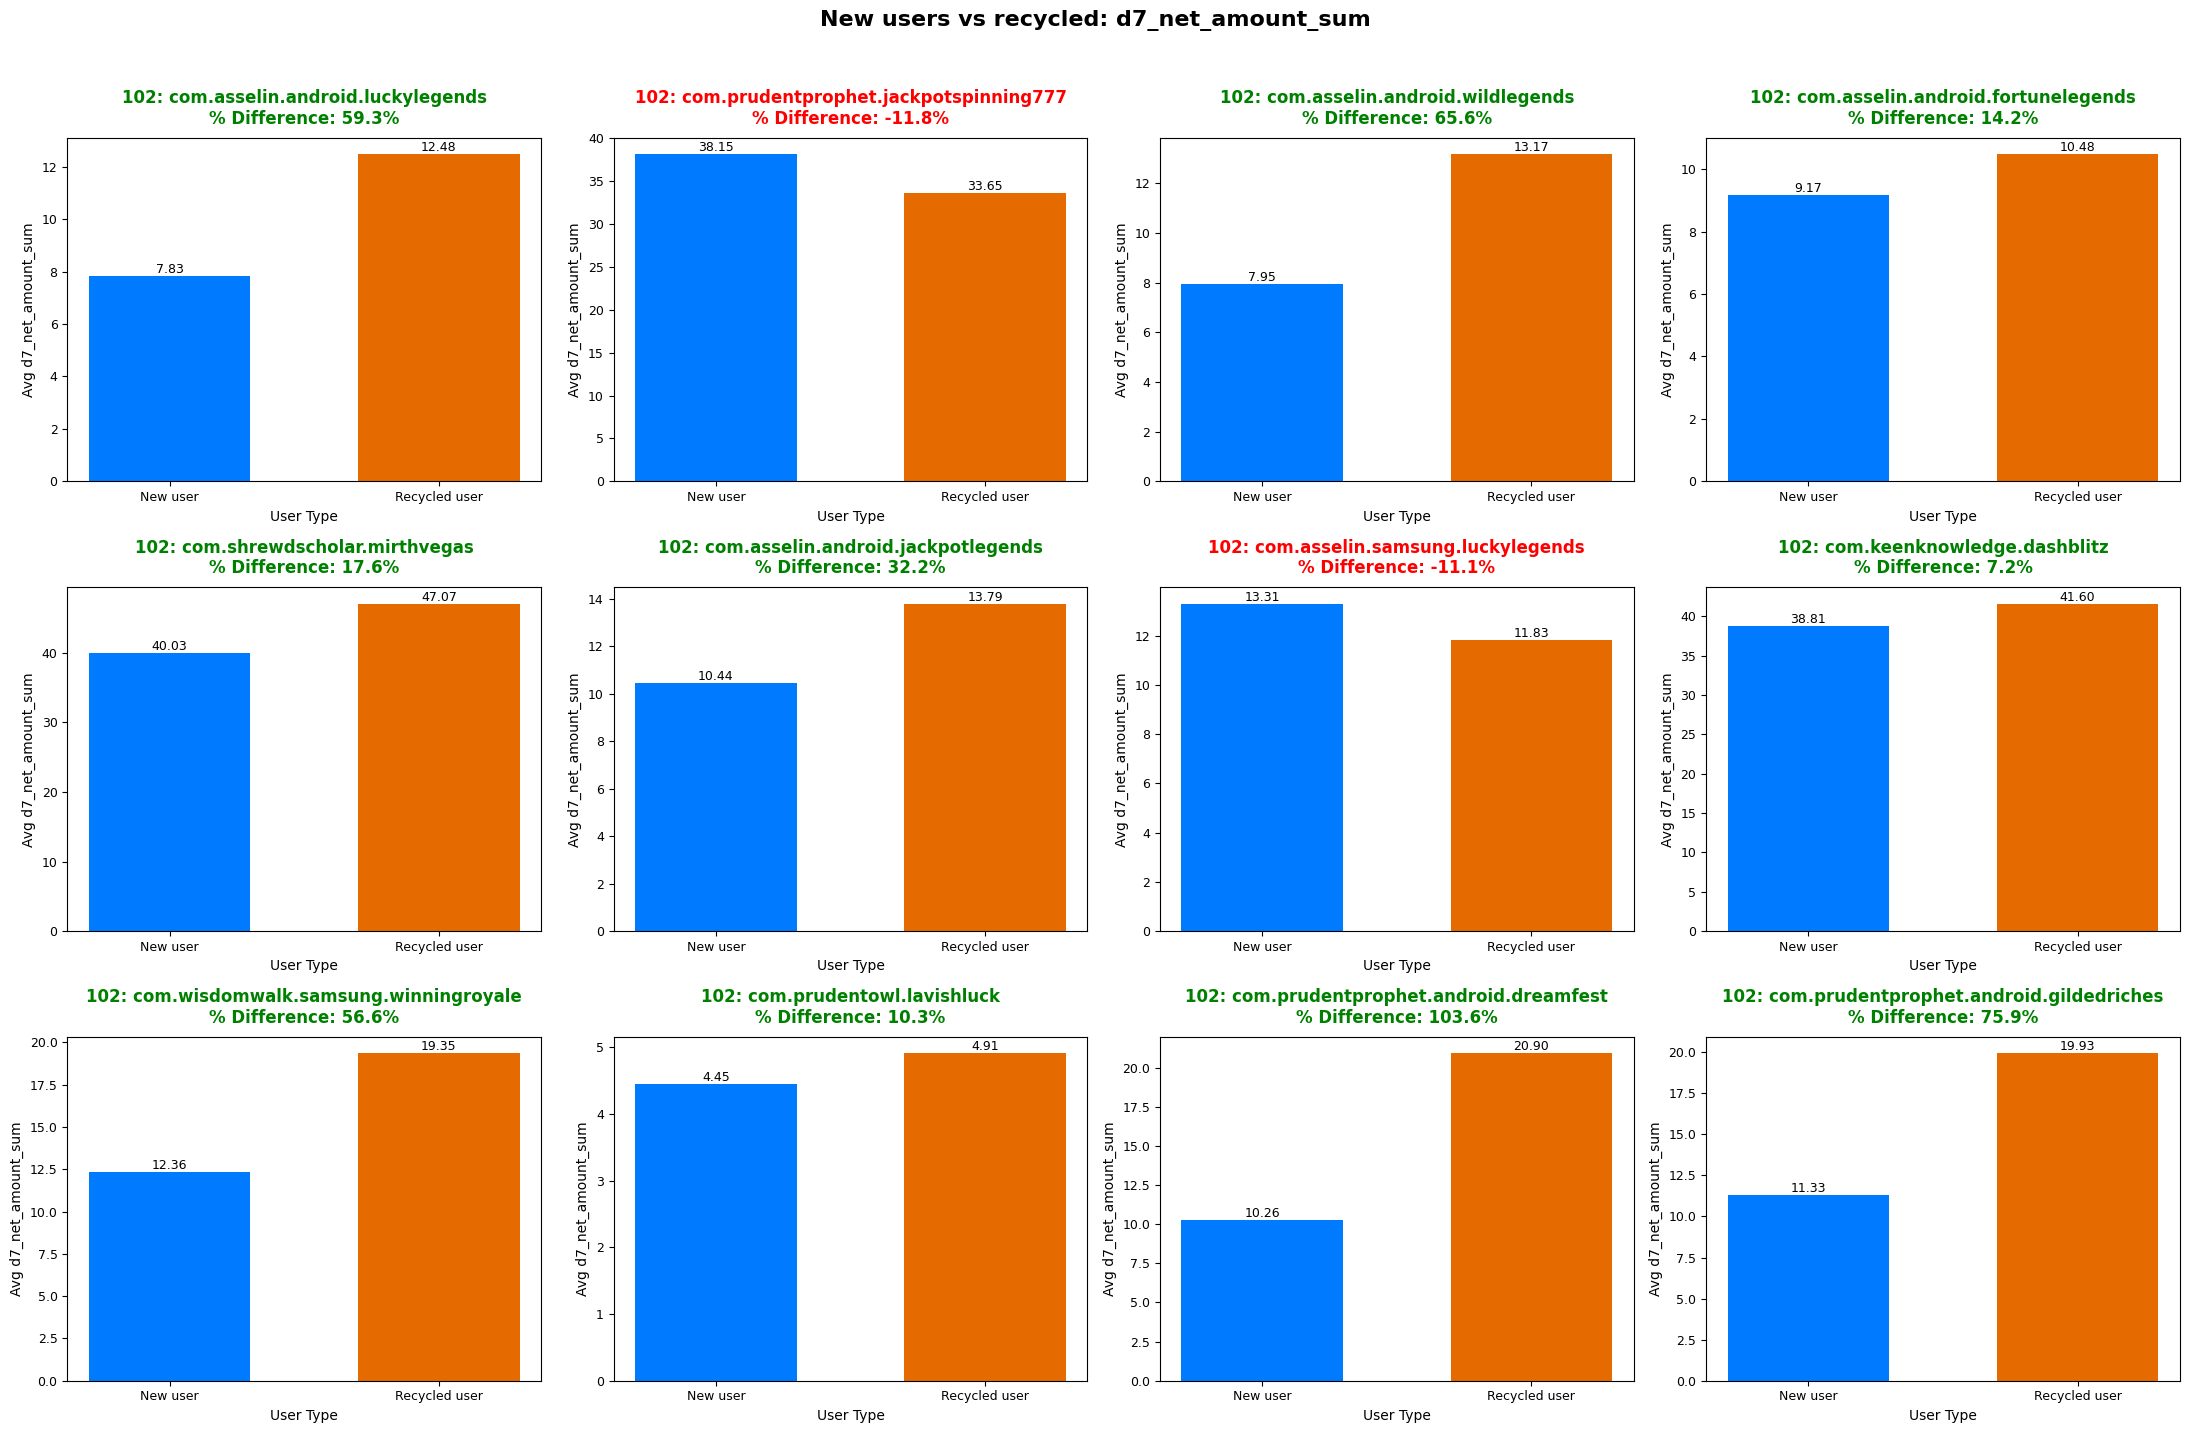

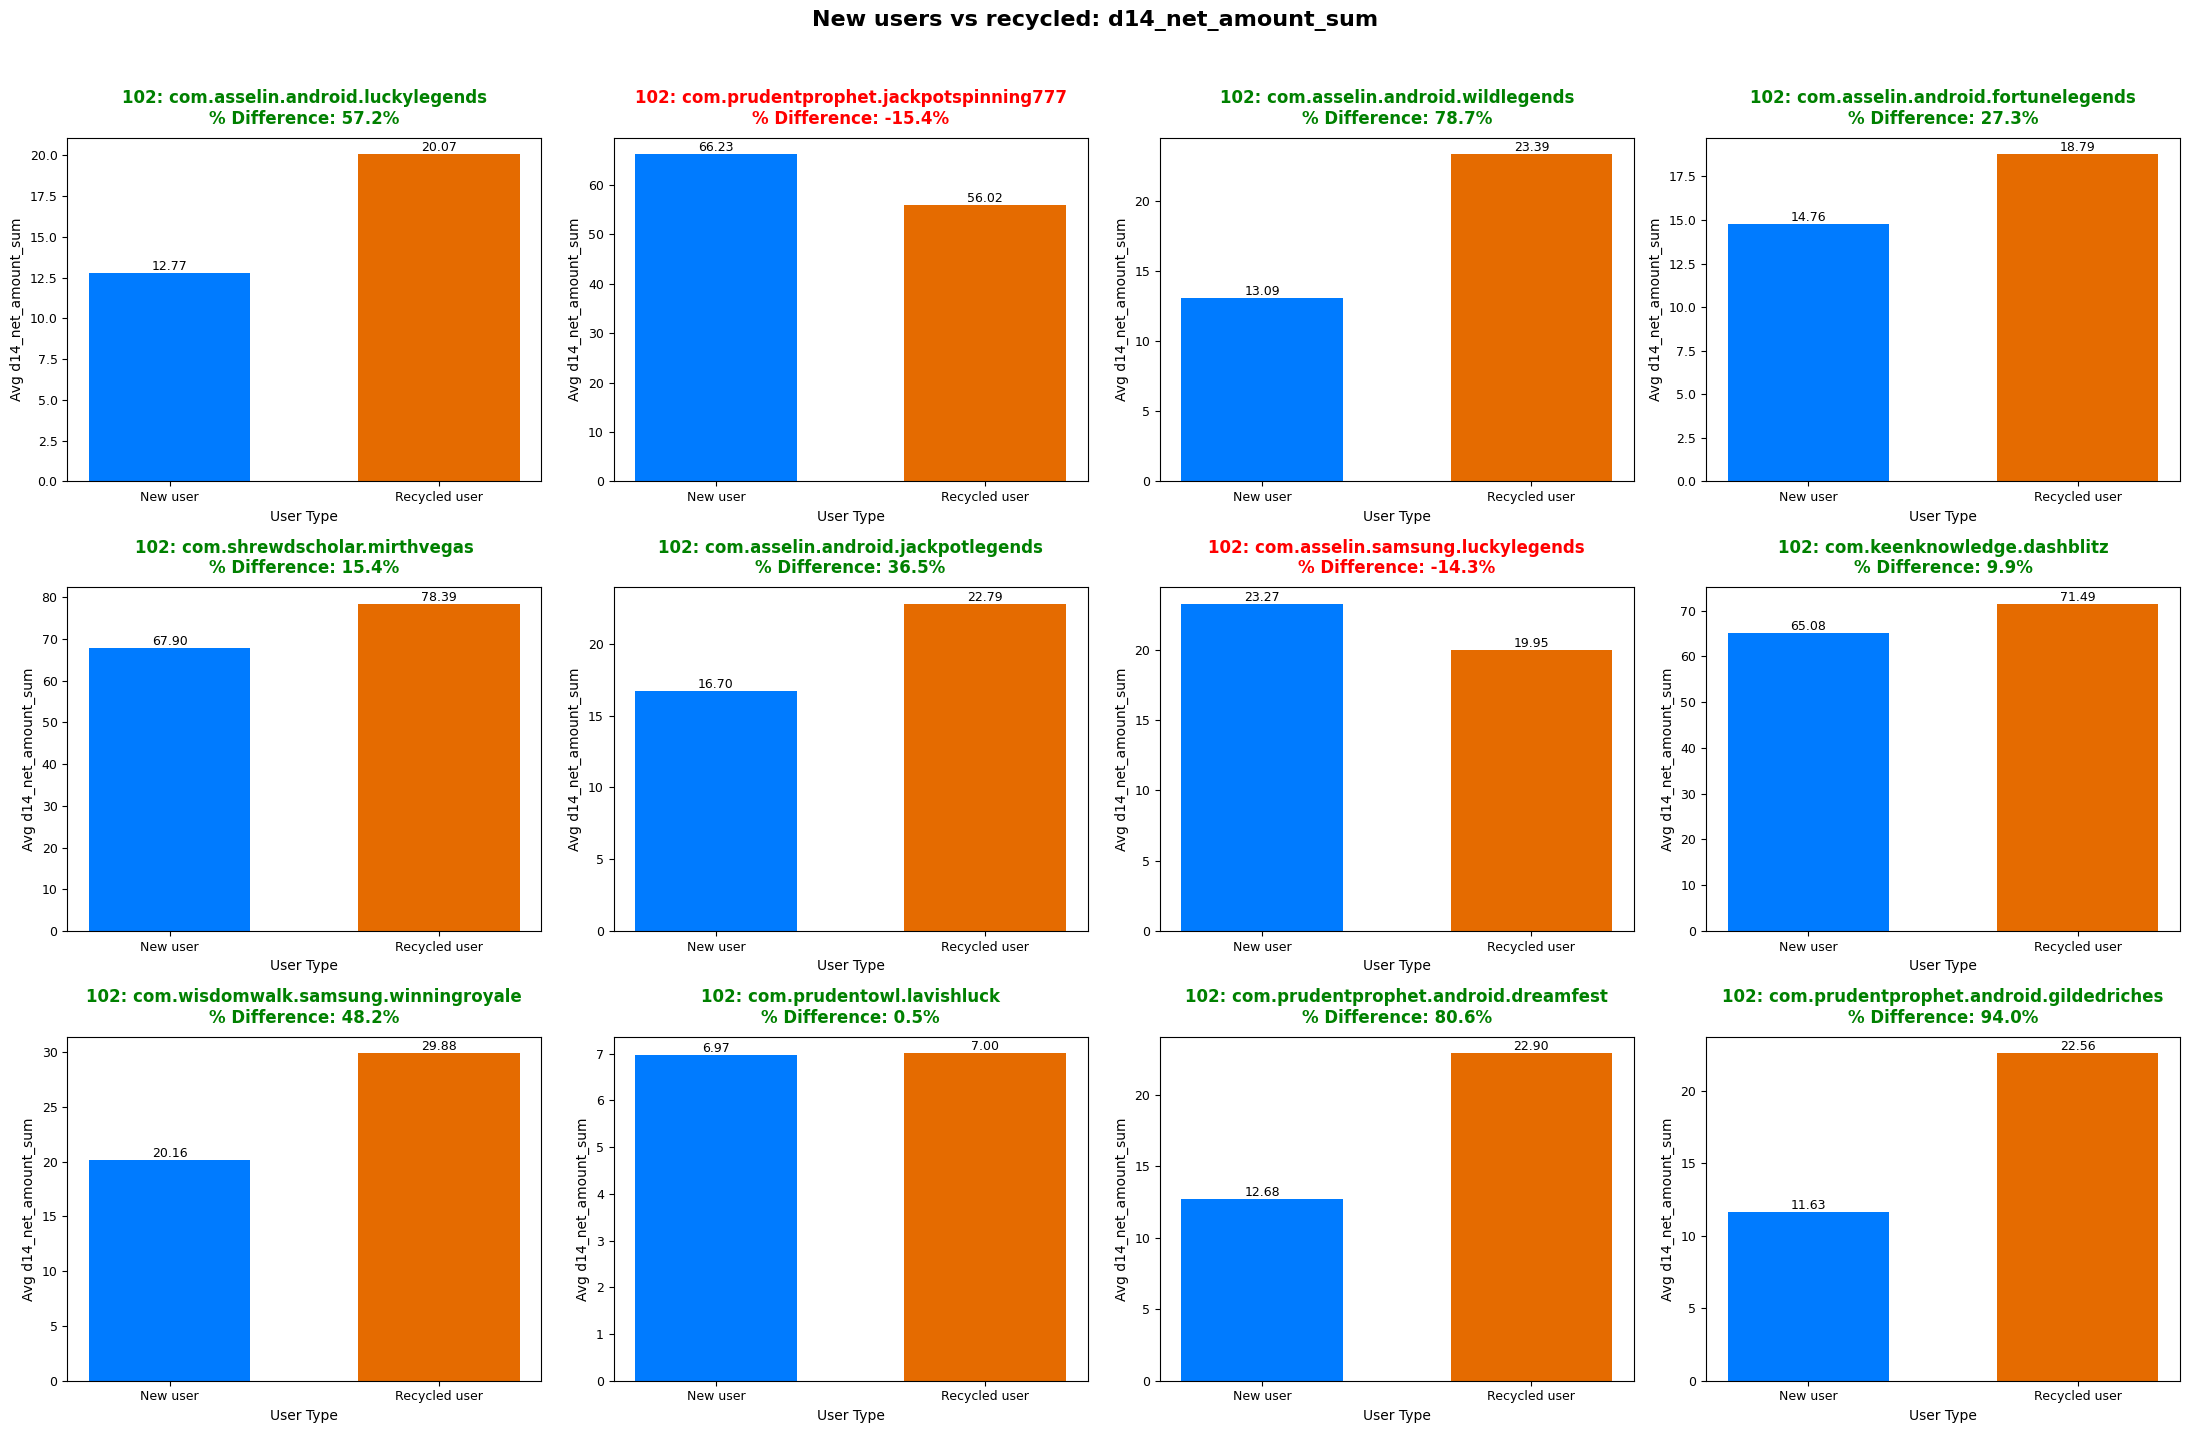

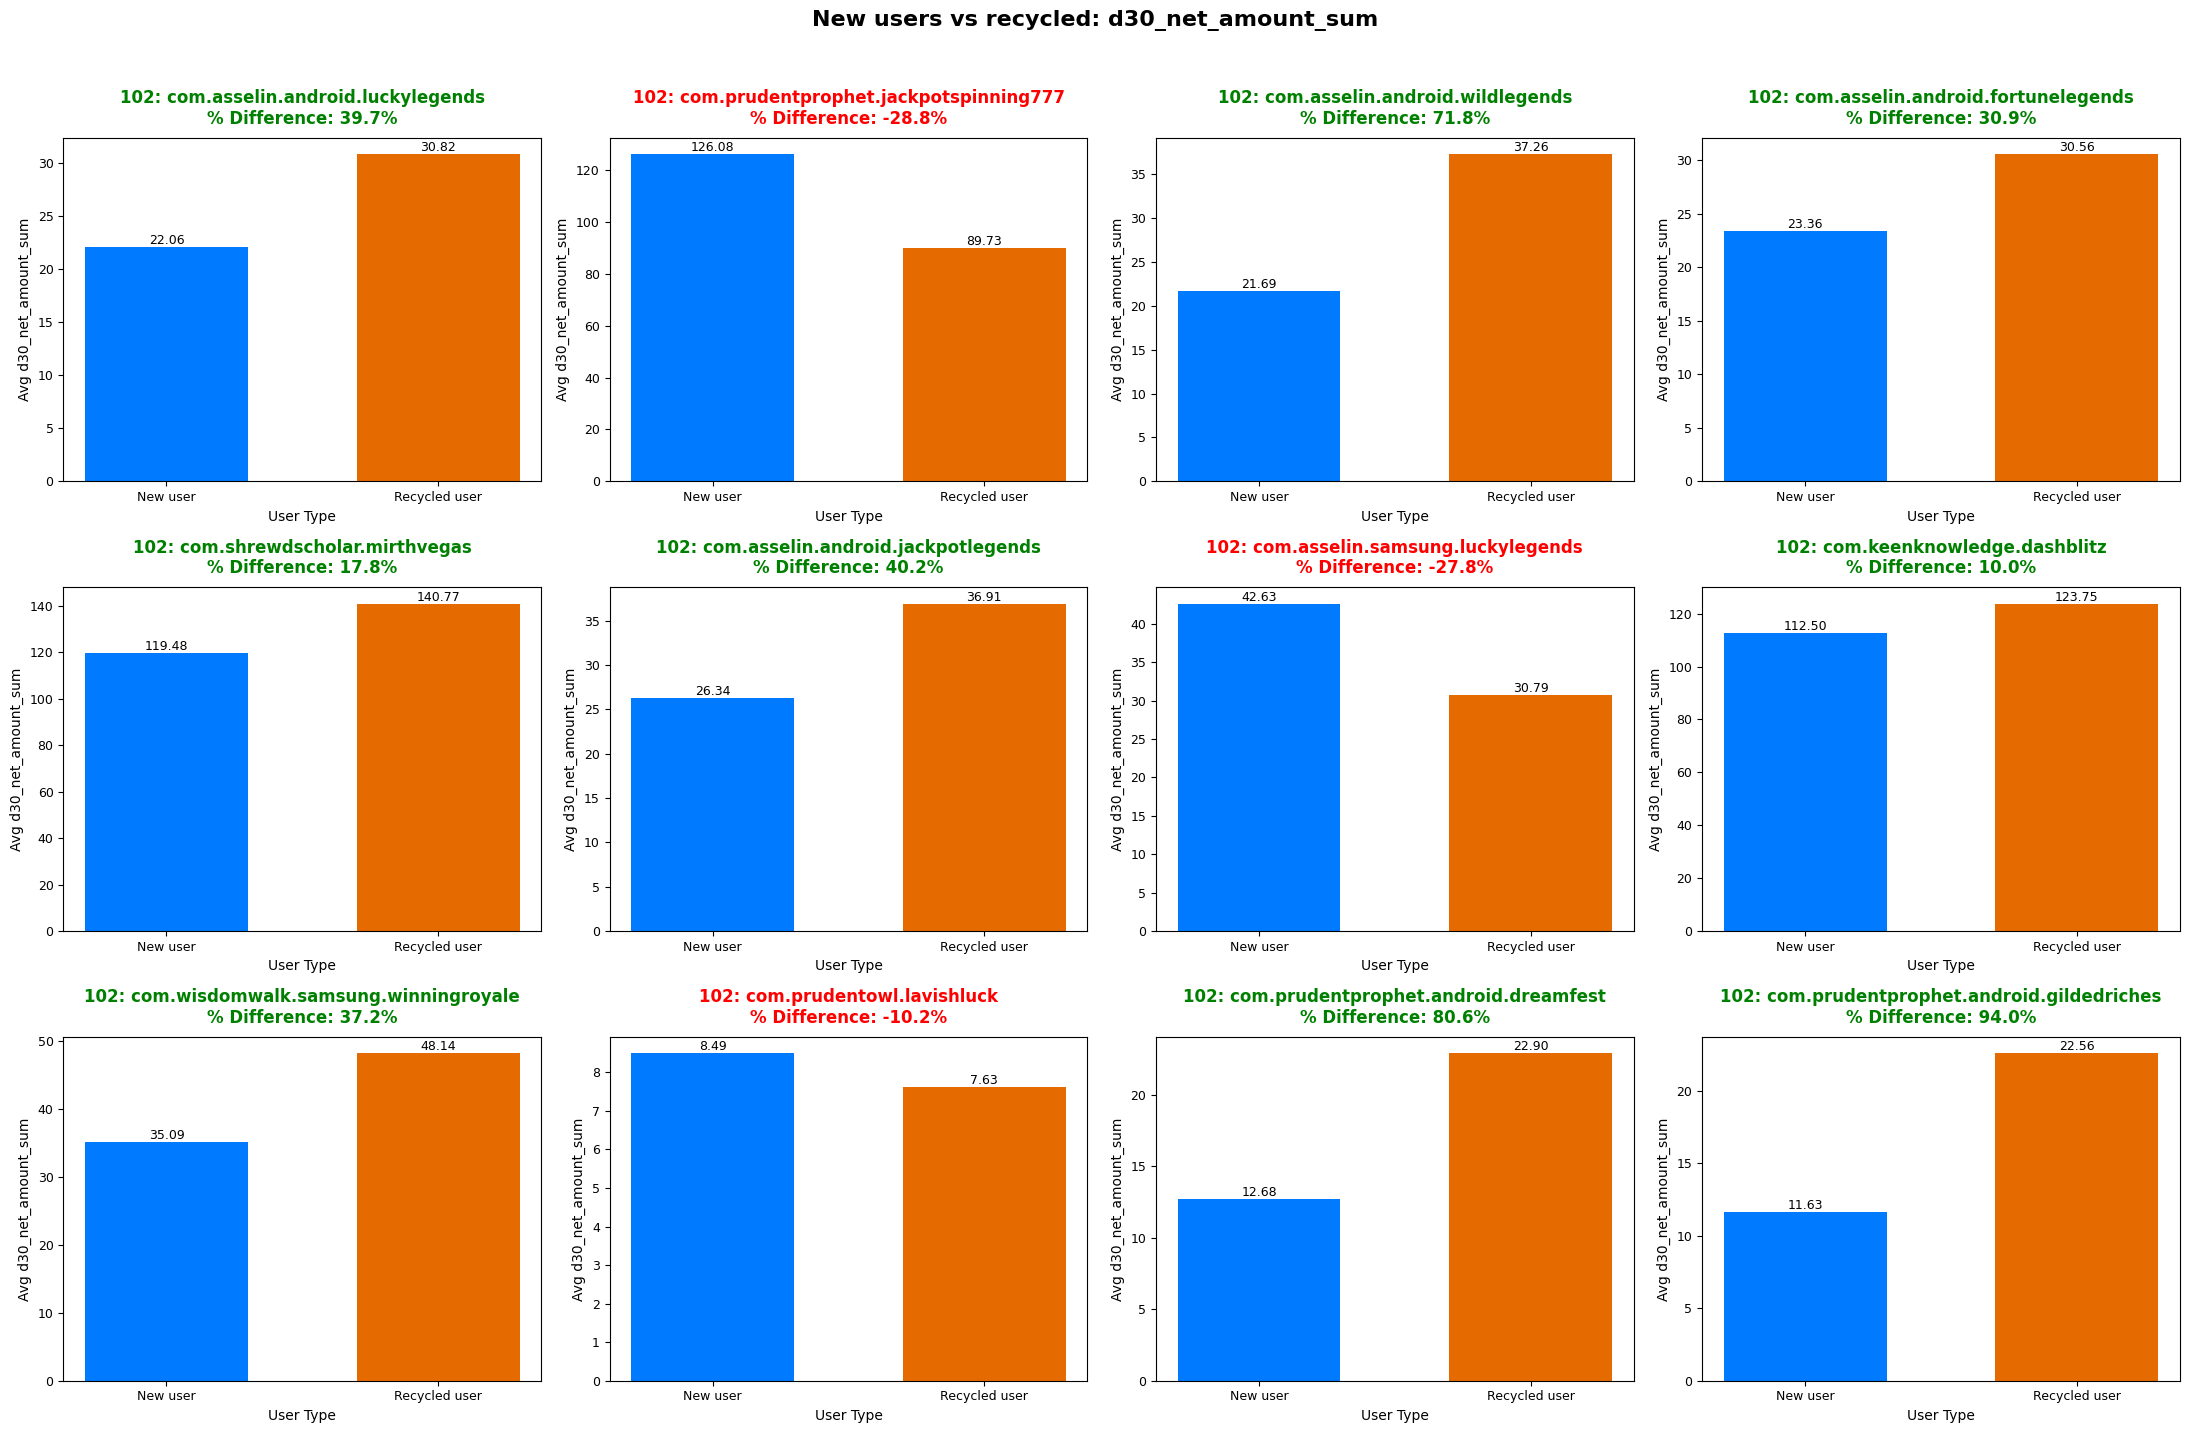

In [15]:
# Display the grouped DataFrame for review
display_dataframe_to_user(name="Grouped Data for Top 9 Games", dataframe=grouped_data)

# Plotting McKinsey-style charts for the new metrics
for col in time_columns:
    plt.figure(figsize=(22, 14))
    for i, game in enumerate(top_12_games, start=1):
        subset = grouped_data[grouped_data['game'] == game]
        
        # Extract New user and Recycled user values
        new_user_value = subset[subset['Treatment'] == 'New user'][col].values[0]
        recycled_user_value = subset[subset['Treatment'] == 'Recycled user'][col].values[0]
        
        # Calculate percentage difference
        percentage_diff = ((recycled_user_value - new_user_value) / new_user_value) * 100
        
        # Set up subplot
        plt.subplot(3, 4, i)
        bars = plt.bar(subset['Treatment'], subset[col], color=['#007bff', '#e56b00'], width=0.6)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
        
        # Title with percentage difference
        diff_color = 'green' if percentage_diff > 0 else 'red'
        plt.title(
            f'{game}\n% Difference: {percentage_diff:.1f}%', 
            fontsize=12, weight='bold', pad=10, color=diff_color
        )
        
        # Axes labels
        plt.xlabel('User Type', fontsize=10)
        plt.ylabel(f'Avg {col}', fontsize=10)
        
        # Format ticks
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)
        plt.grid(False)

    # Adjust layout for each metric
    plt.suptitle(f'New users vs recycled: {col}', fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### Make it into a dashboard

In [83]:
pip install streamlit


                                              0.0/8.6 MB ? eta -:--:--
                                              0.0/8.6 MB 640.0 kB/s eta 0:00:14
                                              0.0/8.6 MB 640.0 kB/s eta 0:00:14
                                              0.0/8.6 MB 640.0 kB/s eta 0:00:14
                                              0.0/8.6 MB 640.0 kB/s eta 0:00:14
                                              0.0/8.6 MB 640.0 kB/s eta 0:00:14
                                              0.0/8.6 MB 93.7 kB/s eta 0:01:32
                                              0.1/8.6 MB 109.2 kB/s eta 0:01:19
                                              0.1/8.6 MB 121.3 kB/s eta 0:01:11
                                              0.1/8.6 MB 121.3 kB/s eta 0:01:11
                                              0.1/8.6 MB 119.1 kB/s eta 0:01:13
                                              0.1/8.6 MB 119.1 kB/s eta 0:01:13
                                              0.1/


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


2024-11-19 10:08:30.833 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 10:08:30.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 10:08:30.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 10:08:30.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 10:08:30.837 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 10:08:30.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 10:08:31.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 10:08:33.246 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

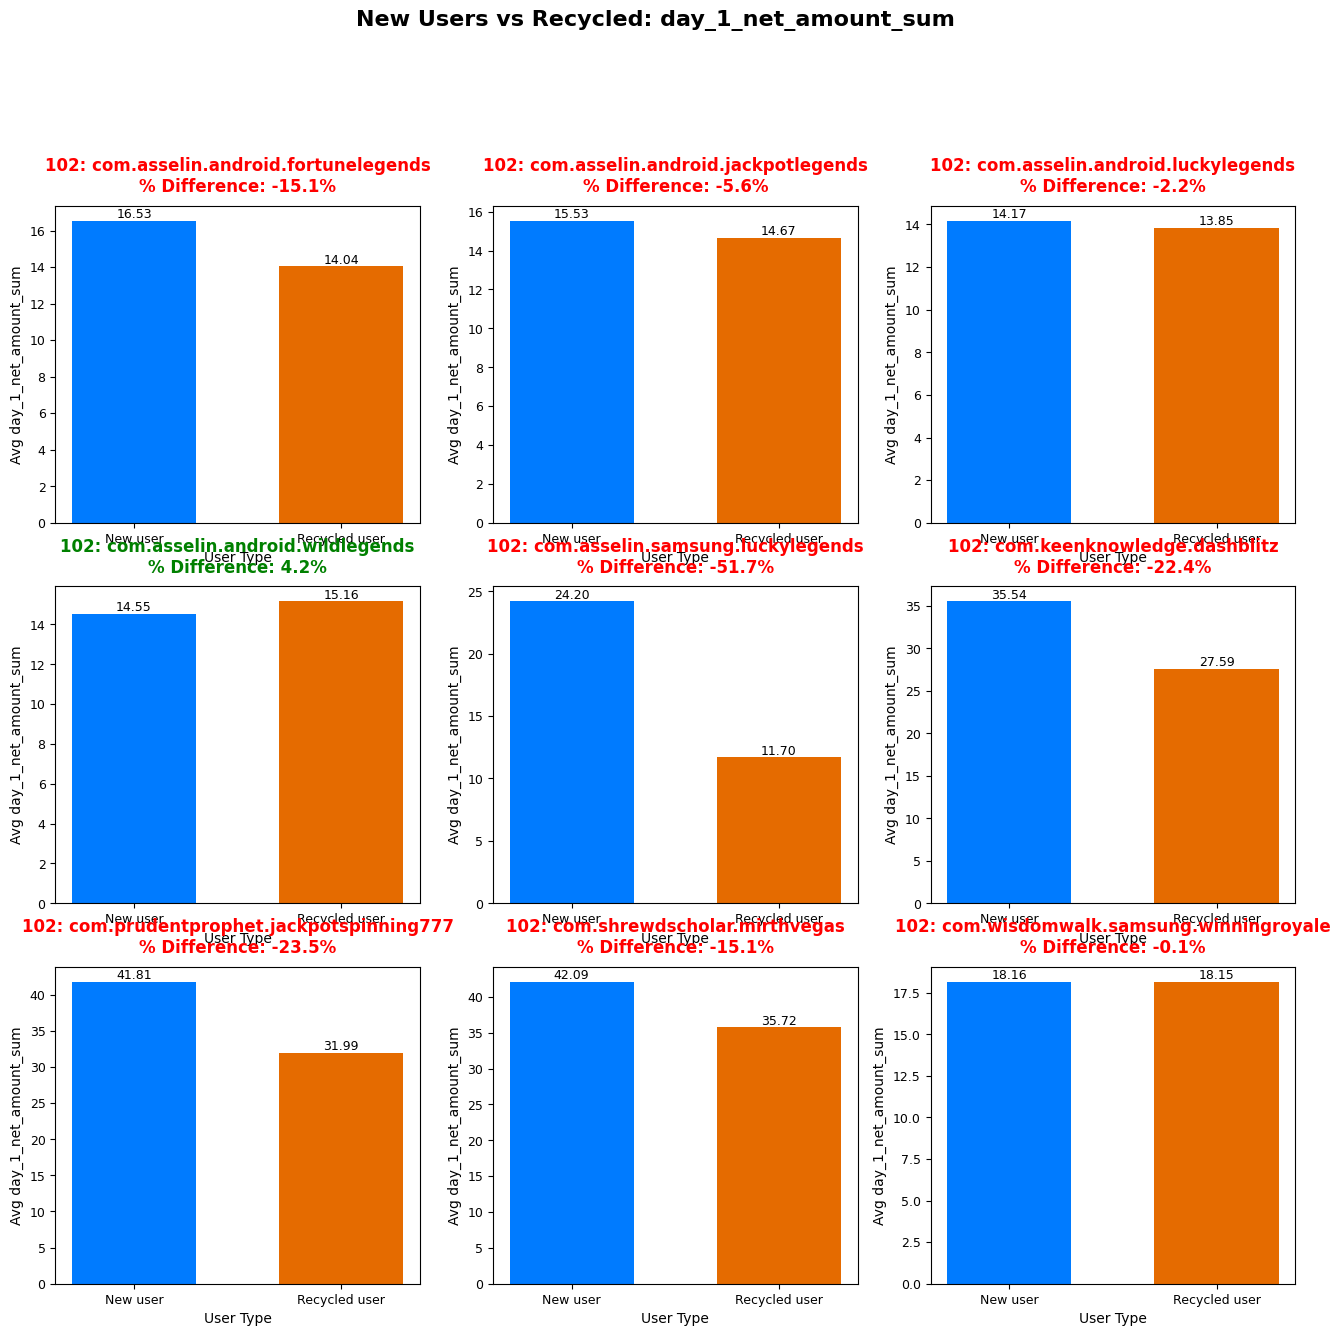

In [88]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# List of metrics for dropdown
time_columns = [
    'day_1_net_amount_sum',
    'day_3_net_amount_sum',
    'day_7_net_amount_sum',
    'day_14_net_amount_sum',
    'day_30_net_amount_sum'
]

# Dropdown to select metric
selected_metric = st.sidebar.selectbox('Select a metric:', time_columns)

# Top games for visualization
top_9_games = grouped_data['game'].unique()[:9]  # Replace with your logic to filter top games

# Plot function
def plot_metric(data, metric):
    plt.figure(figsize=(16, 14))
    for i, game in enumerate(top_9_games, start=1):
        subset = data[data['game'] == game]
        
        new_user_value = subset[subset['Treatment'] == 'New user'][metric].values[0]
        recycled_user_value = subset[subset['Treatment'] == 'Recycled user'][metric].values[0]
        
        # Calculate percentage difference
        percentage_diff = ((recycled_user_value - new_user_value) / new_user_value) * 100
        
        plt.subplot(3, 3, i)
        bars = plt.bar(subset['Treatment'], subset[metric], color=['#007bff', '#e56b00'], width=0.6)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
        
        # Title with percentage difference
        diff_color = 'green' if percentage_diff > 0 else 'red'
        plt.title(
            f'{game}\n% Difference: {percentage_diff:.1f}%', 
            fontsize=12, weight='bold', pad=10, color=diff_color
        )
        
        # Axes labels
        plt.xlabel('User Type', fontsize=10)
        plt.ylabel(f'Avg {metric}', fontsize=10)
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)
        plt.grid(False)

    plt.suptitle(f'New Users vs Recycled: {metric}', fontsize=16, weight='bold', y=1.02)
    st.pyplot(plt)

# Display chart for the selected metric
plot_metric(grouped_data, selected_metric)


# Part II: Analyse nth users after game X as first game

In [114]:
# You need to analyse further data
df

,#account_id,d14_net_amount_sum,d14_withdrawn_amount,d1_net_amount_sum,d1_withdrawn_amount,d30_net_amount_sum,d30_withdrawn_amount,d3_net_amount_sum,d3_withdrawn_amount,d7_net_amount_sum,d7_withdrawn_amount,email,freq_d1,freq_d14,freq_d3,freq_d30,freq_d7,game,nth_game,register_time
0,40452858,54.3400,94.5,1.61,0.0,103.5600,94.50,1.61,0.0,20.470,74.5,Lovemyemily1@yahoo.com,1,14,1,22,8,102: com.asselin.samsung.luckylegends,1,2024-06-18 20:01:30.000
1,40444715,2.5700,0.0,2.57,0.0,2.5700,0.00,2.57,0.0,2.570,0.0,Mclaughlin.kim.m@gmail.com,1,1,1,1,1,102: com.asselin.samsung.luckylegends,1,2024-06-16 14:58:29.000
2,40629982,812.8000,693.0,47.10,0.0,4579.9500,4623.50,47.10,0.0,141.300,0.0,Christy_0234@yahoo.com,1,23,2,84,6,102: com.keenknowledge.dashblitz,1,2024-08-14 03:02:28.000
3,40526990,3.2480,0.0,0.00,0.0,3.2480,0.00,0.00,0.0,3.248,0.0,johnnyroxx1980@gmail.com,0,2,0,2,2,102: com.asselin.android.wildlegends,1,2024-07-17 01:46:28.000
4,40552279,0.0000,0.0,0.00,0.0,NaN,3.35,0.00,0.0,0.000,0.0,Stephaniegibbons2004@icloud.com,0,0,0,1,0,102: com.prudentprophet.jackpotspinning777,1,2024-07-27 01:18:27.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95425,40953052,1.8300,0.0,1.83,0.0,1.8300,0.00,1.83,0.0,1.830,0.0,kimberleyperkey@gmail.com,1,1,1,1,1,102: com.asselin.android.wildlegends,1,2024-10-04 21:14:43.000
95426,40748255,9.2600,0.0,9.26,0.0,9.2600,0.00,9.26,0.0,9.260,0.0,Cornettj85@gmail.com,1,1,1,1,1,102: com.wisdomwalk.samsung.winningroyale,1,2024-08-27 22:53:54.000
95427,40714763,0.7500,0.0,0.00,0.0,0.7500,0.00,0.00,0.0,0.750,0.0,Yeonmi87831@gmail.com,0,1,0,1,1,102: com.prudentprophet.jackpotspinning777,1,2024-08-24 17:08:31.000
95428,40703049,14.1115,0.0,0.00,0.0,14.1115,0.00,0.00,0.0,0.000,0.0,Palmer1965@outlook.com,0,2,0,2,0,102: com.asselin.android.luckylegends,1,2024-08-23 10:26:29.000


In [9]:
# Generate same for ChatGPT
if len(df) >= 20000:
    # Randomly sample 20,000 rows without replacement
    sample_df = df.sample(n=20000, random_state=42)

    # Export the sample to a CSV file
    sample_df.to_csv('sample_20000_rows_for_ggr.csv', index=False)
    print("Sample exported to 'sample_20000_rows.csv'")
else:
    print("The DataFrame has fewer than 20,000 rows. Export not performed.")

Sample exported to 'sample_20000_rows.csv'


In [1]:
# Focus on the top 12 games
top_games_list = top_games_data['game'].value_counts().head(12).index

# Calculate the average day_1_net_amount_sum for each game and nth_game
grouped_data = (
    df[df['game'].isin(top_games_list)]
    .groupby(['game', 'nth_game'])['d1_net_amount_sum']
    .mean()
    .reset_index()
)

grouped_data

NameError: name 'top_games_data' is not defined

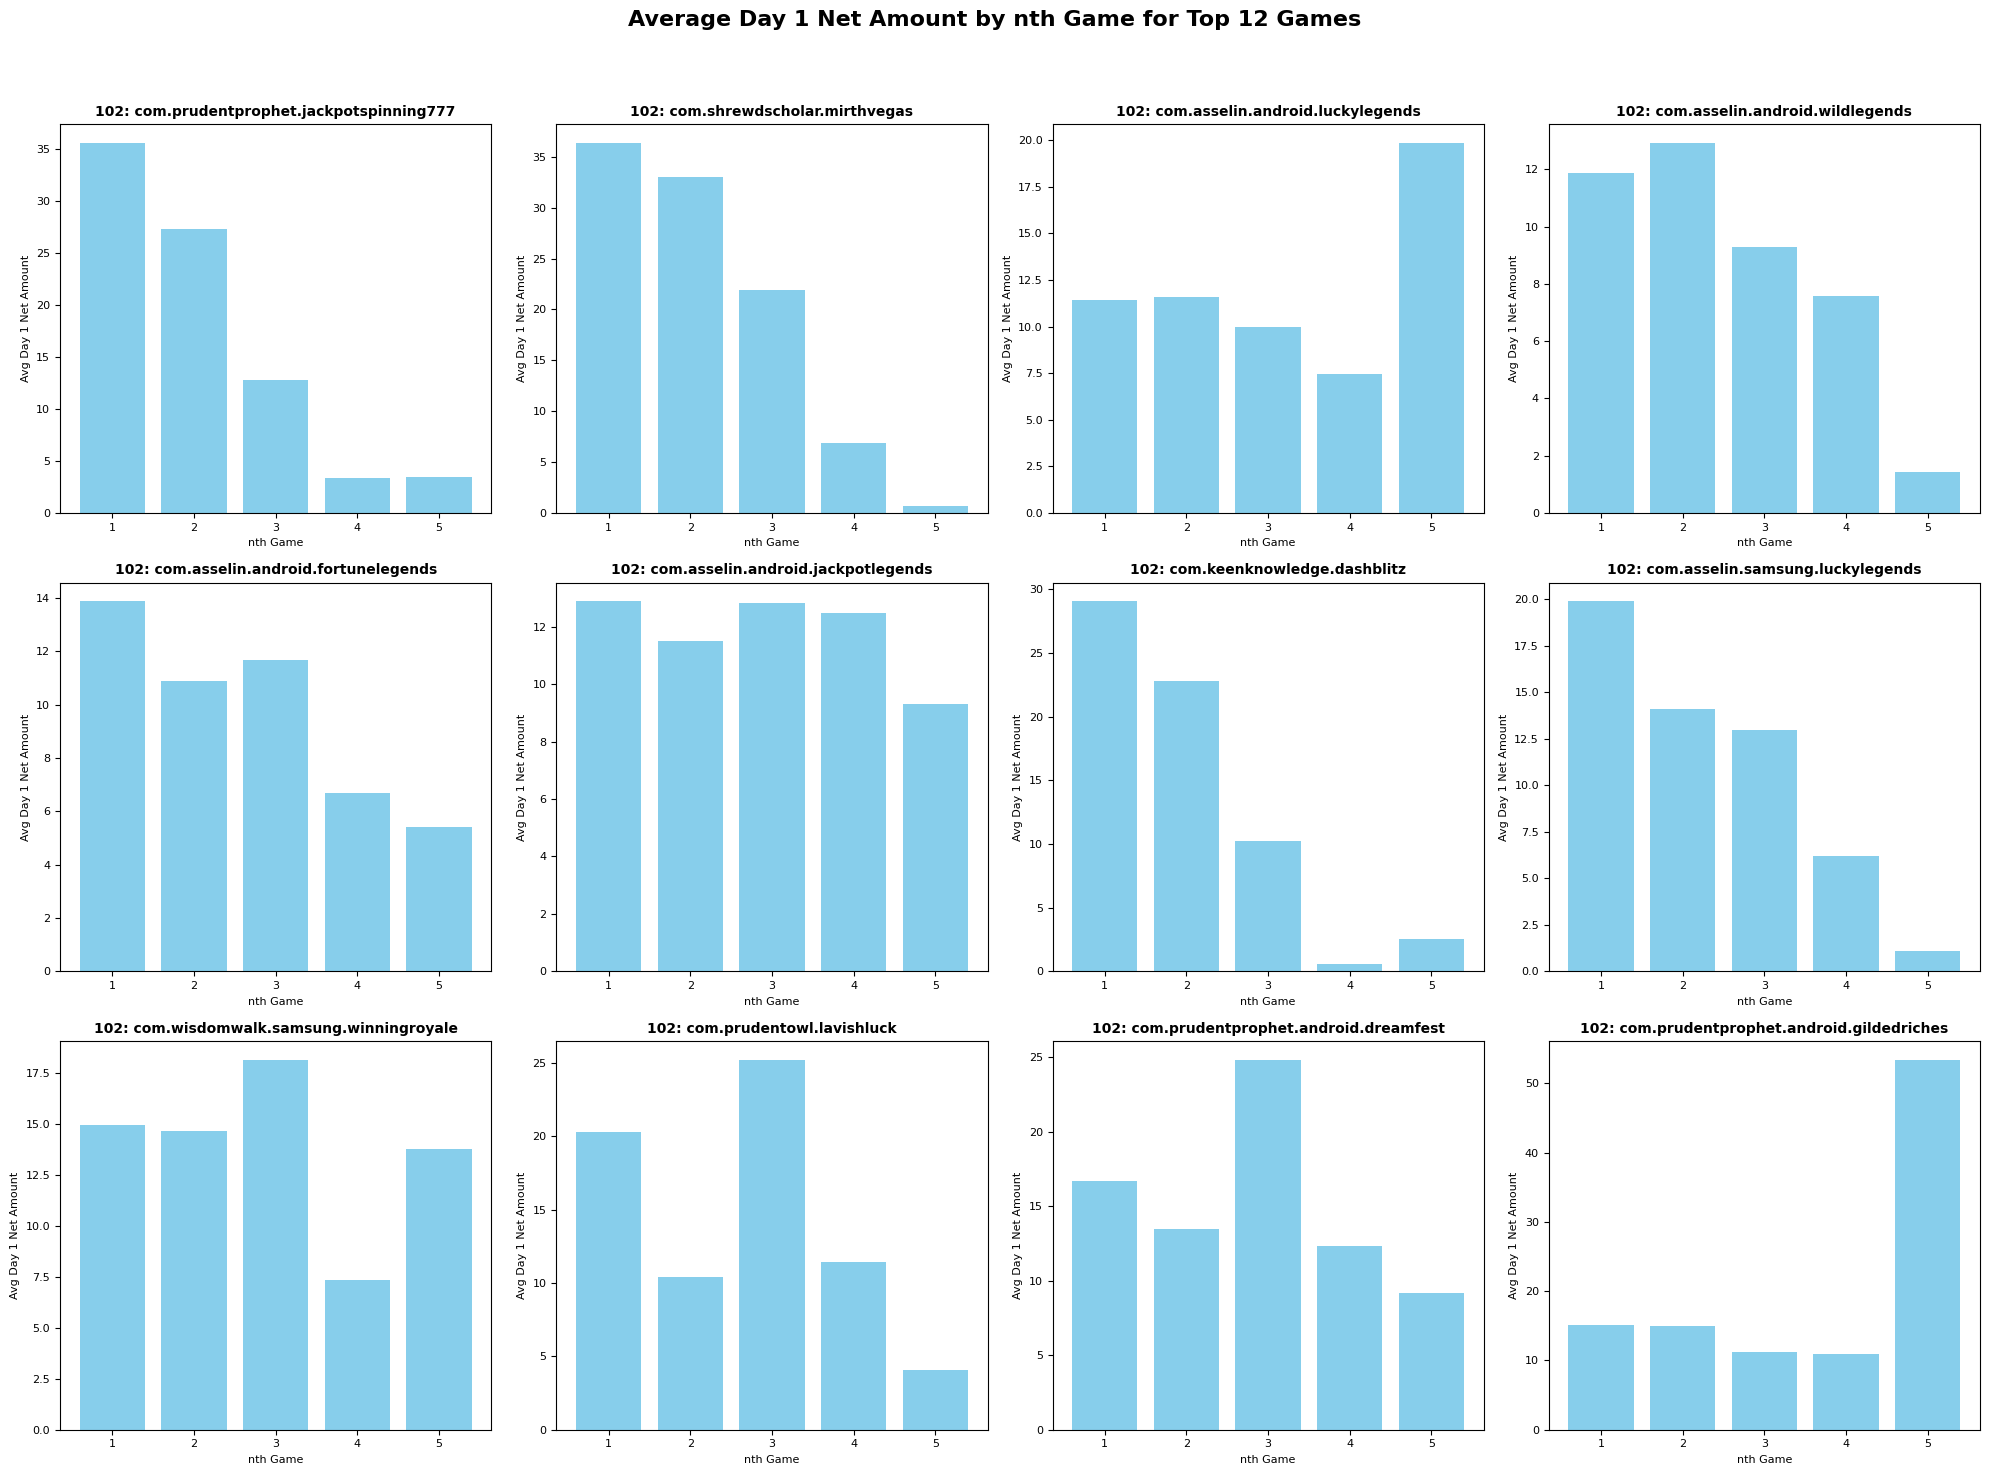

In [119]:
# Set up the multi-plot grid
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle("Average Day 1 Net Amount by nth Game for Top 12 Games", fontsize=16, weight='bold')

# Iterate over each game to create individual plots
for (game, ax) in zip(top_games_list, axes.flatten()):
    # Filter data for the current game
    game_data = grouped_data[grouped_data['game'] == game]
    
    # Plot the data
    ax.bar(game_data['nth_game'], game_data['d1_net_amount_sum'], color='skyblue')
    
    # Set titles and labels
    ax.set_title(game, fontsize=10, weight='bold')
    ax.set_xlabel("nth Game", fontsize=8)
    ax.set_ylabel("Avg Day 1 Net Amount", fontsize=8)
    ax.set_xticks(game_data['nth_game'])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [120]:
df['game'].sample(20)

8889          102: com.asselin.android.luckylegends
39985             102: com.shrewdscholar.mirthvegas
70226              102: com.keenknowledge.dashblitz
56387       102: com.asselin.android.jackpotlegends
7225          102: com.asselin.android.luckylegends
31180     102: com.prudentprophet.android.dreamfest
76272       102: com.asselin.android.jackpotlegends
14723    102: com.prudentprophet.jackpotspinning777
86556    102: com.prudentprophet.jackpotspinning777
10765       102: com.asselin.android.fortunelegends
72303       102: com.asselin.android.fortunelegends
12359       102: com.asselin.android.fortunelegends
21709          102: com.asselin.android.wildlegends
51147             102: com.shrewdscholar.mirthvegas
32096         102: com.asselin.android.luckylegends
78423          102: com.asselin.android.wildlegends
8514           102: com.asselin.android.wildlegends
1942          102: com.asselin.android.luckylegends
51252             102: com.shrewdscholar.mirthvegas
84707       

In [121]:
print(df['#account_id'].nunique())
print(df.shape)

95430
(95430, 20)


In [80]:
user_ids_first_game

df[df['#account_id'].isin(user_ids_first_game)]

,#account_id,day_14_net_amount_sum,day_1_net_amount_sum,day_30_net_amount_sum,day_3_net_amount_sum,day_7_net_amount_sum,email,game,nth_game,register_time
2,40545767,81.699,9.120,81.699,17.062,58.589,Hopebowen12@yahoo.com,102: com.prudentprophet.jackpotspinning777,1,2024-07-24 05:41:11.000
14,40565599,2.561,0.000,2.561,0.000,2.561,Peterollins01@hotmail.com,102: com.prudentprophet.jackpotspinning777,1,2024-07-31 05:56:45.000
15,40532085,214.010,102.070,214.010,214.010,214.010,Margie.bibbs@yahoo.com,102: com.prudentprophet.jackpotspinning777,1,2024-07-19 01:42:50.000
19,40649027,2.650,2.650,2.650,2.650,2.650,Scott.pacansky@aol.com,102: com.prudentprophet.jackpotspinning777,1,2024-08-16 21:08:46.000
21,40640655,102.350,102.350,102.350,102.350,102.350,Melissapopolo@gmail.com,102: com.prudentprophet.jackpotspinning777,1,2024-08-15 18:35:15.000
...,...,...,...,...,...,...,...,...,...,...
79052,40732555,1.700,1.700,1.700,1.700,1.700,Dwedly66@gmail.com,102: com.prudentprophet.jackpotspinning777,1,2024-08-26 06:46:46.000
79055,40535308,94.761,30.171,94.761,48.661,94.761,Mkjordan1958@yahoo.com,102: com.prudentprophet.jackpotspinning777,1,2024-07-20 06:57:32.000
79058,40691040,106.450,0.000,106.450,13.850,25.800,Kirahall13@gmail.com,102: com.prudentprophet.jackpotspinning777,1,2024-08-22 01:29:02.000
79064,40599570,2.650,2.650,2.650,2.650,2.650,Stottlemyremary@gmail.com,102: com.prudentprophet.jackpotspinning777,1,2024-08-09 04:18:03.000


   nth_game  d1_net_amount_sum                                        game
0         1          35.621348  102: com.prudentprophet.jackpotspinning777
1         2          33.748219  102: com.prudentprophet.jackpotspinning777
2         3          24.433308  102: com.prudentprophet.jackpotspinning777
3         4           8.230110  102: com.prudentprophet.jackpotspinning777
4         5          71.468745  102: com.prudentprophet.jackpotspinning777


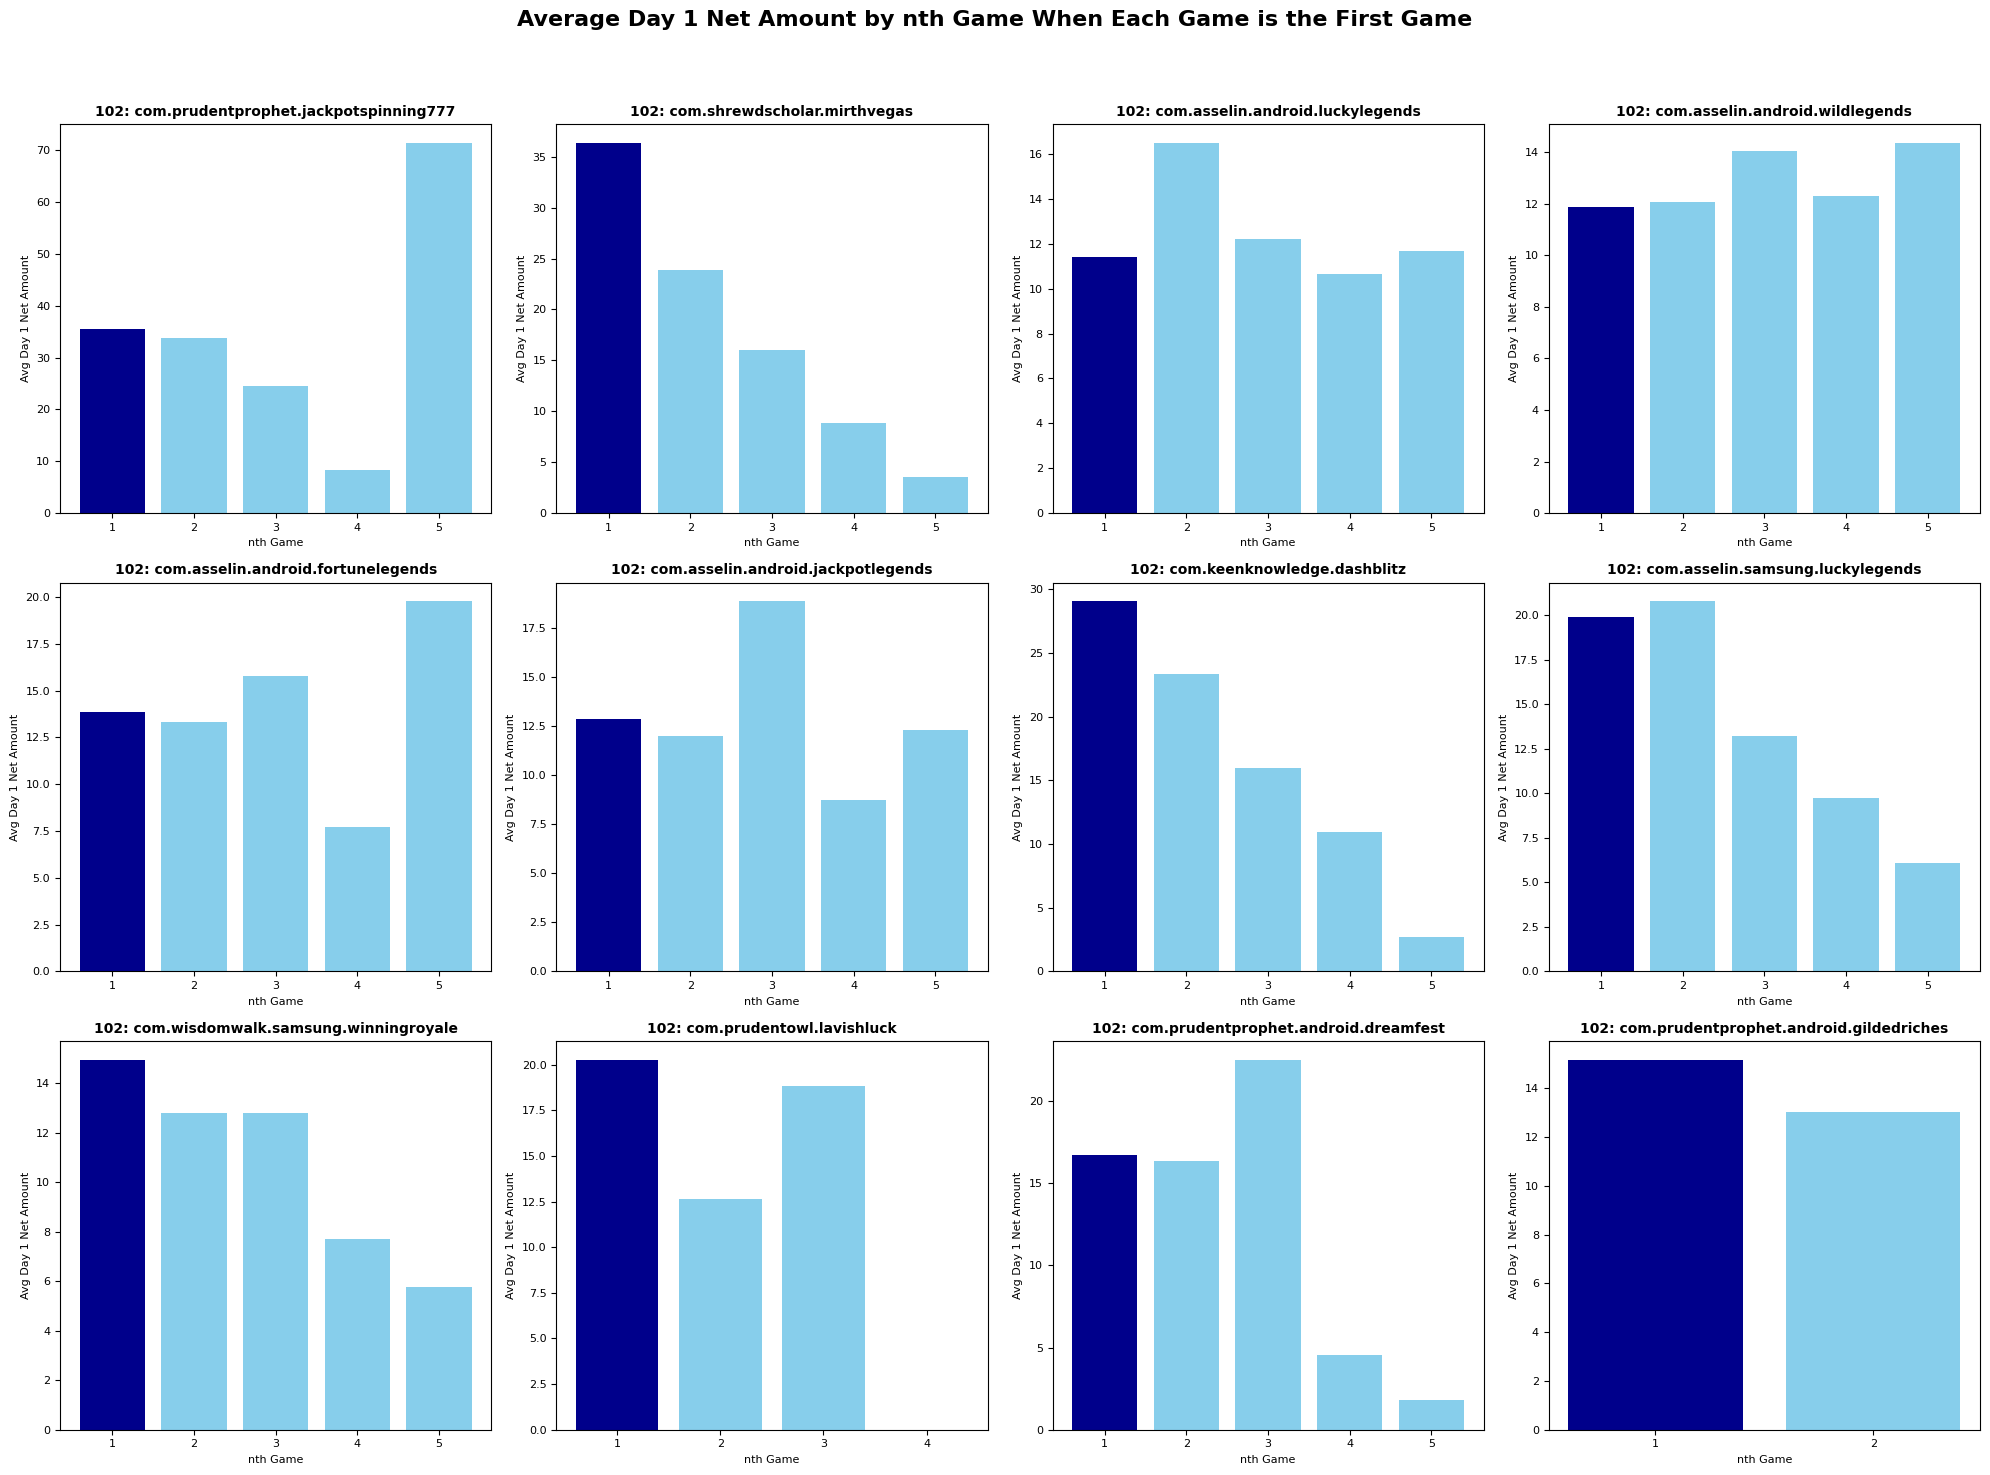

In [123]:
# Filter data to focus on scenarios where each game is the first game played (nth_game = 1)
first_game_data = df[df['nth_game'] == 1]

# Prepare for storing results for each game's scenario
result_data = []

# Iterate over each game and calculate the average day_1_net_amount_sum for subsequent games
for game in top_games_list:
    # Filter for users where the current game is the first game played
    user_ids_first_game = first_game_data[first_game_data['game'] == game]['email']
    
    # Filter the full dataset for these users
    user_data = df[df['email'].isin(user_ids_first_game)]
    
    # Group by nth_game to calculate the average day_1_net_amount_sum
    averages = (
        user_data.groupby('nth_game')['d1_net_amount_sum']
        .mean()
        .reset_index()
        .sort_values(by='nth_game')
    )
    averages['game'] = game  # Add game name for context
    result_data.append(averages)

# Combine all results into a single DataFrame
plot_data = pd.concat(result_data, ignore_index=True)

# Display the data for review before plotting
print(plot_data.head())  # Displaying the first few rows for quick review

# Set up the multi-plot grid
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle("Average Day 1 Net Amount by nth Game When Each Game is the First Game", fontsize=16, weight='bold')

# Iterate over each game to create individual plots
for (game, ax) in zip(top_games_list, axes.flatten()):
    # Filter data for the current game scenario
    game_data = plot_data[plot_data['game'] == game]
    
    # Highlight the first bar
    colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]
    
    # Plot the data
    ax.bar(game_data['nth_game'], game_data['d1_net_amount_sum'], color=colors)
    
    # Set titles and labels
    ax.set_title(game, fontsize=10, weight='bold')
    ax.set_xlabel("nth Game", fontsize=8)
    ax.set_ylabel("Avg Day 1 Net Amount", fontsize=8)
    ax.set_xticks(game_data['nth_game'])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


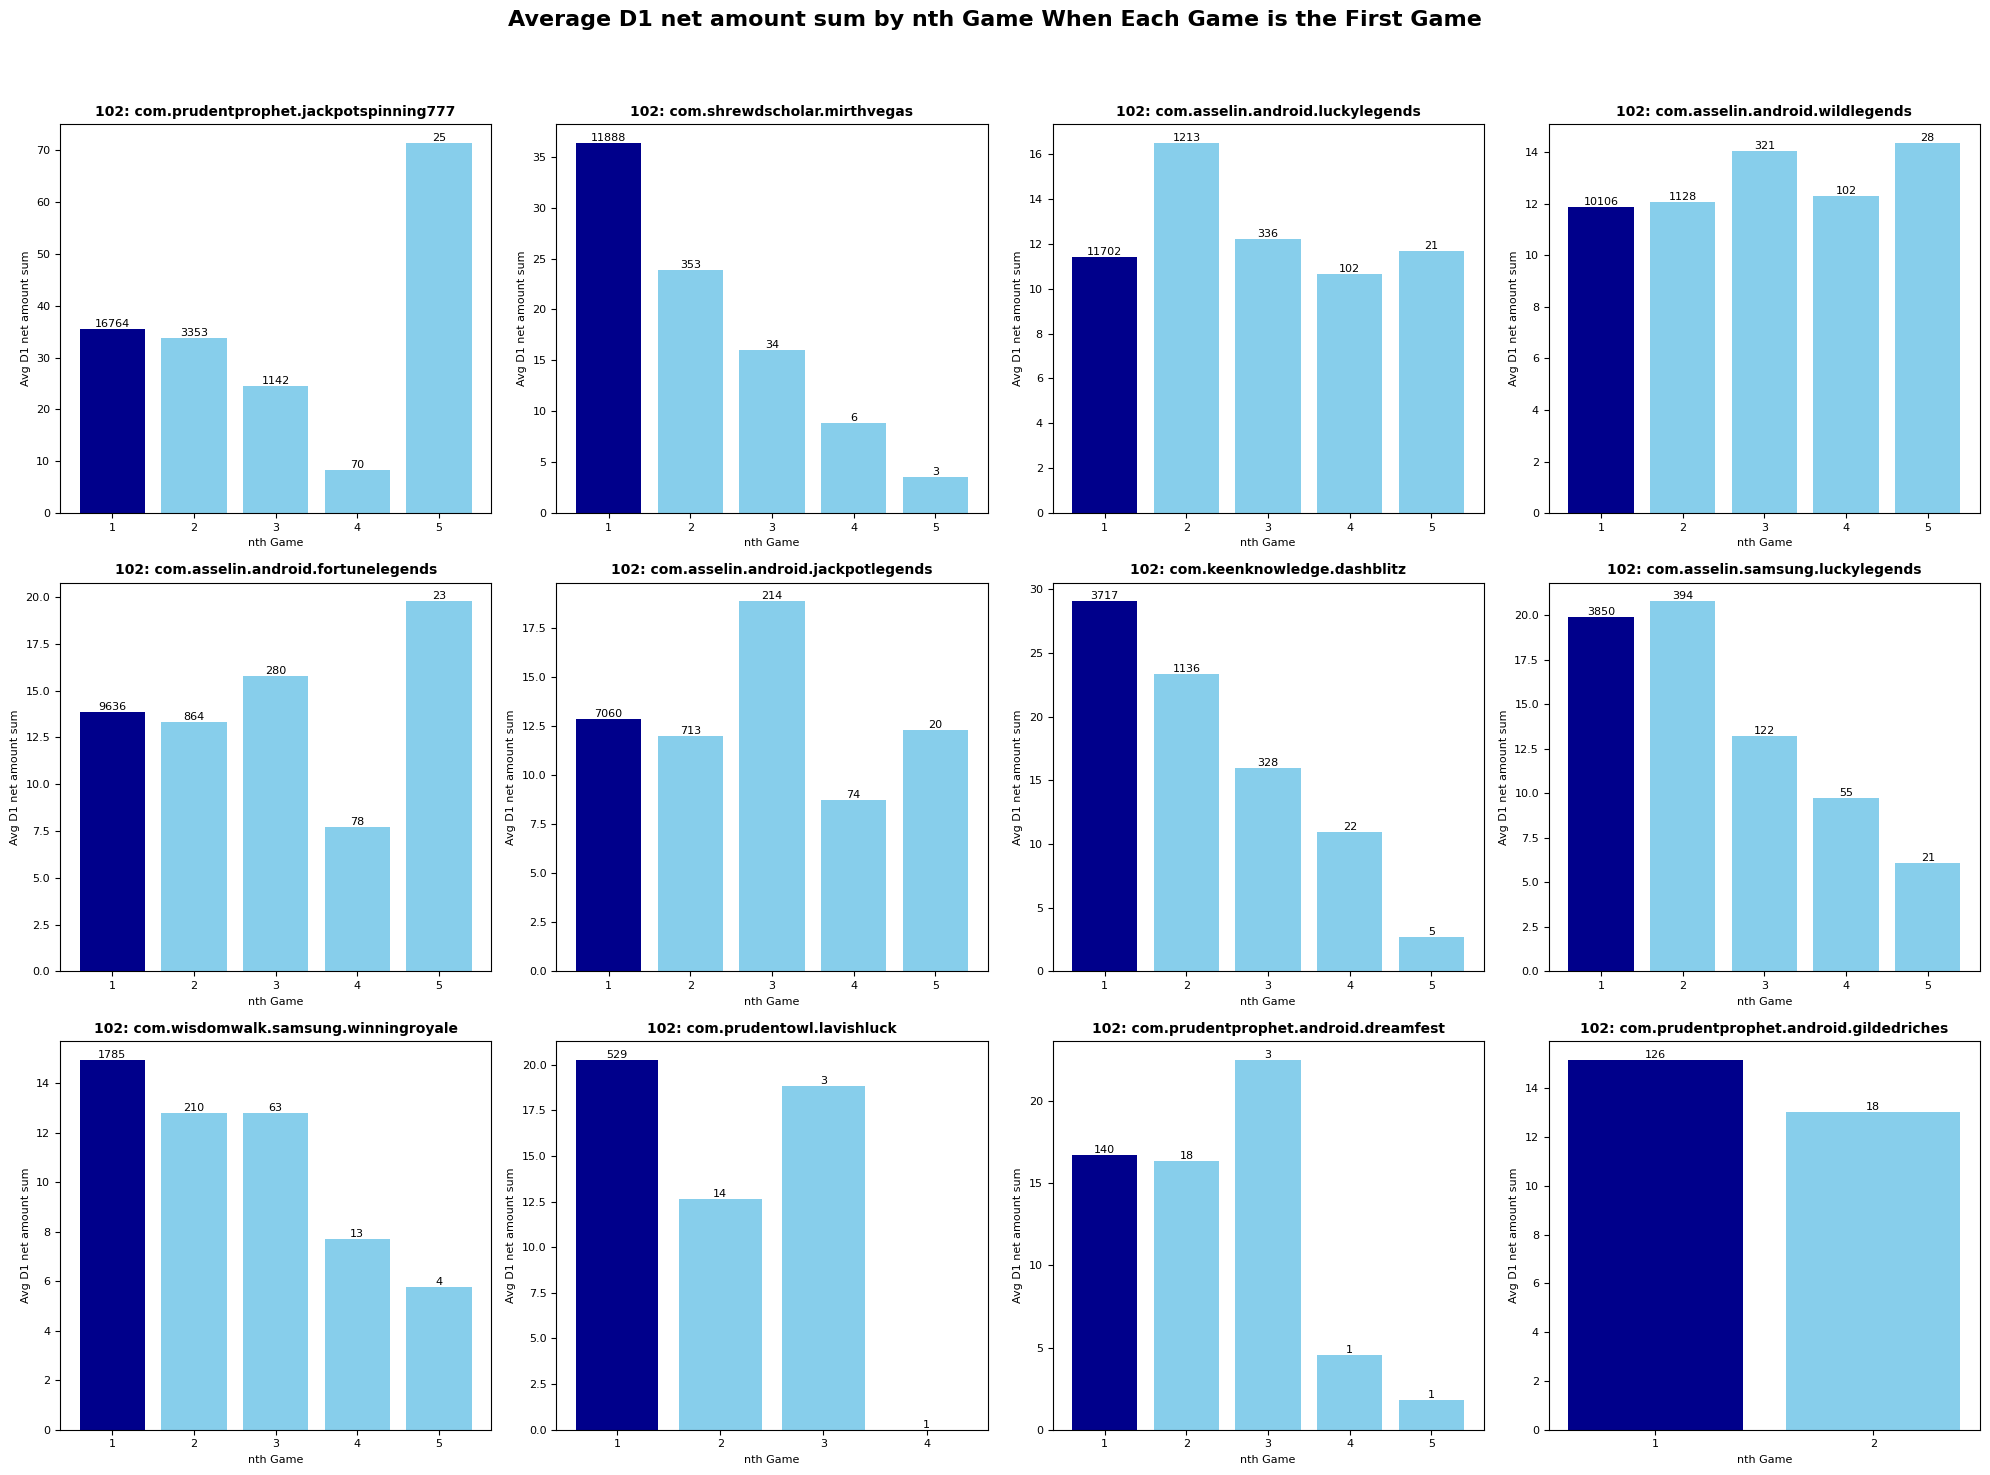

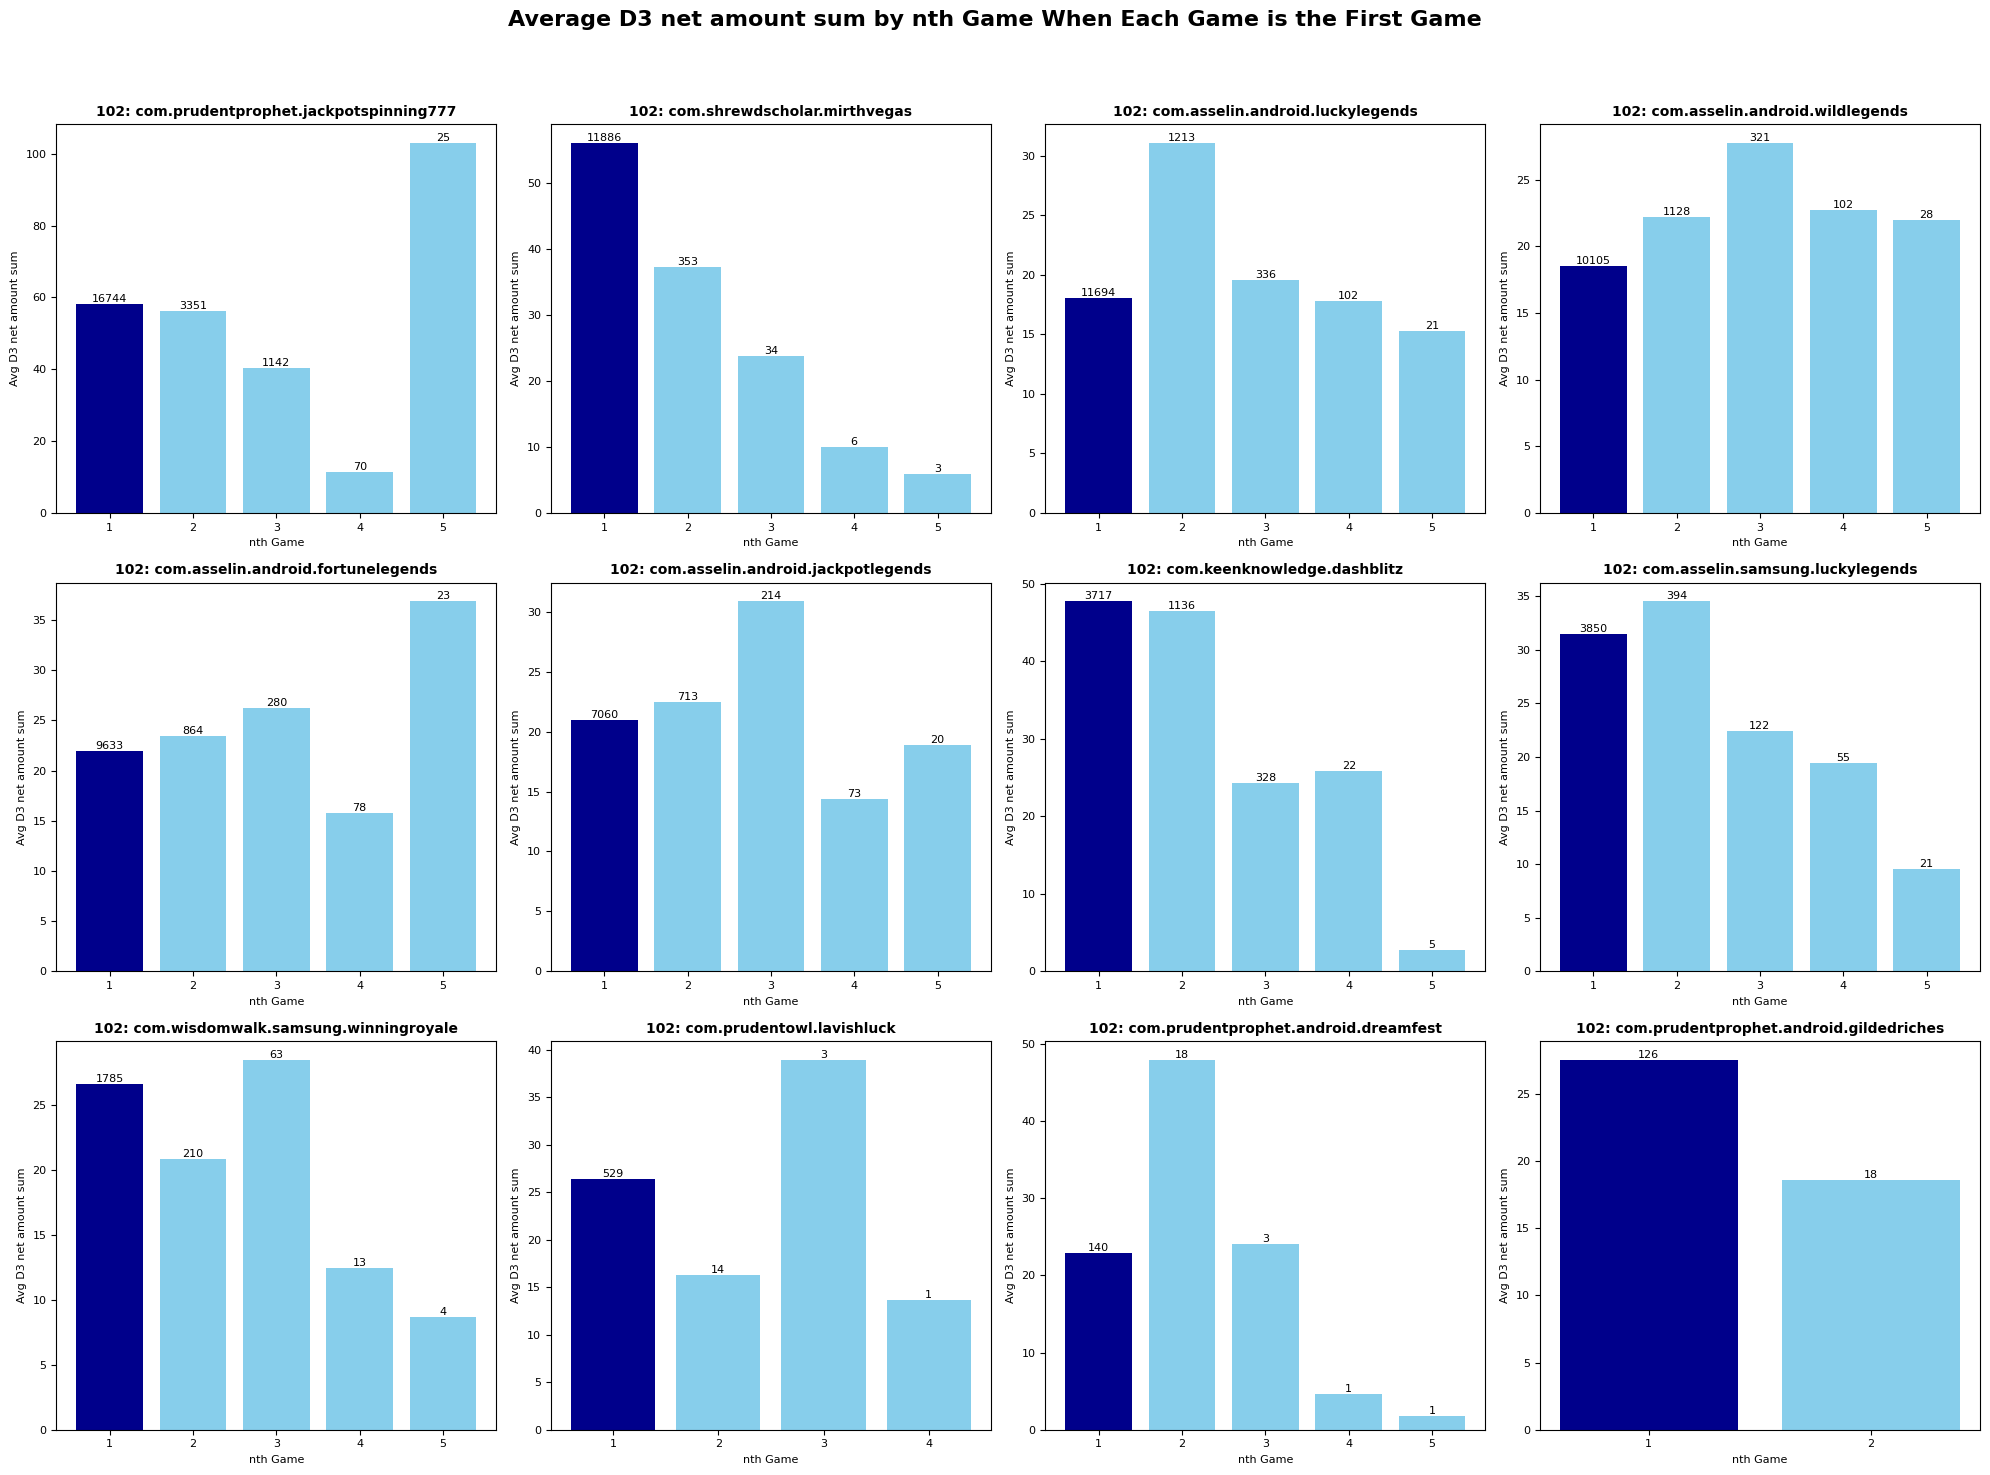

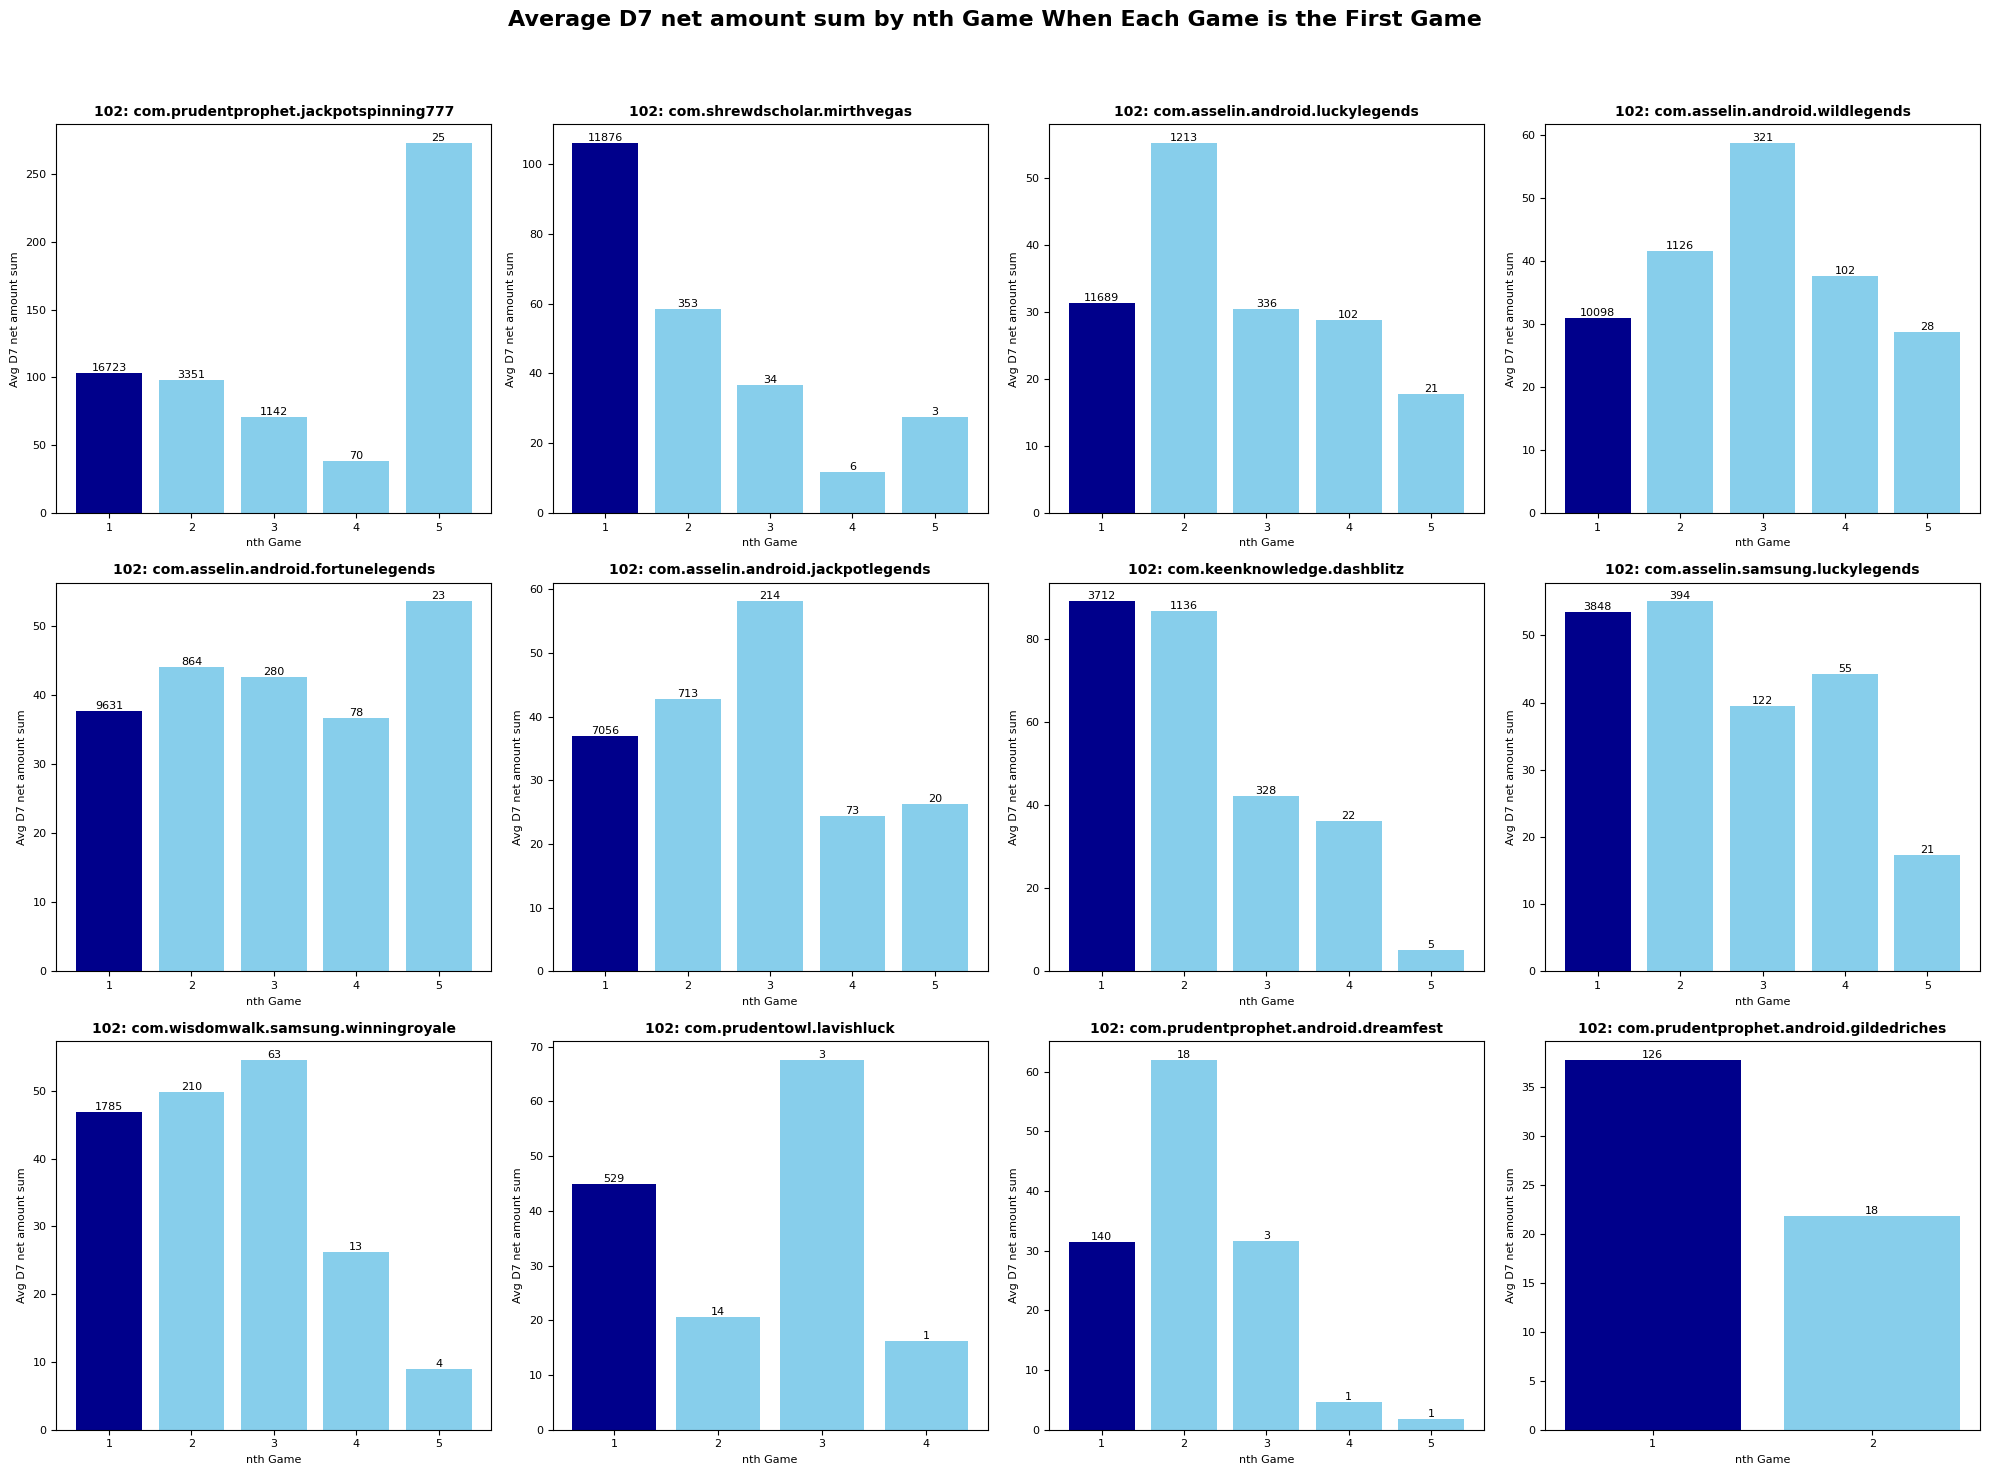

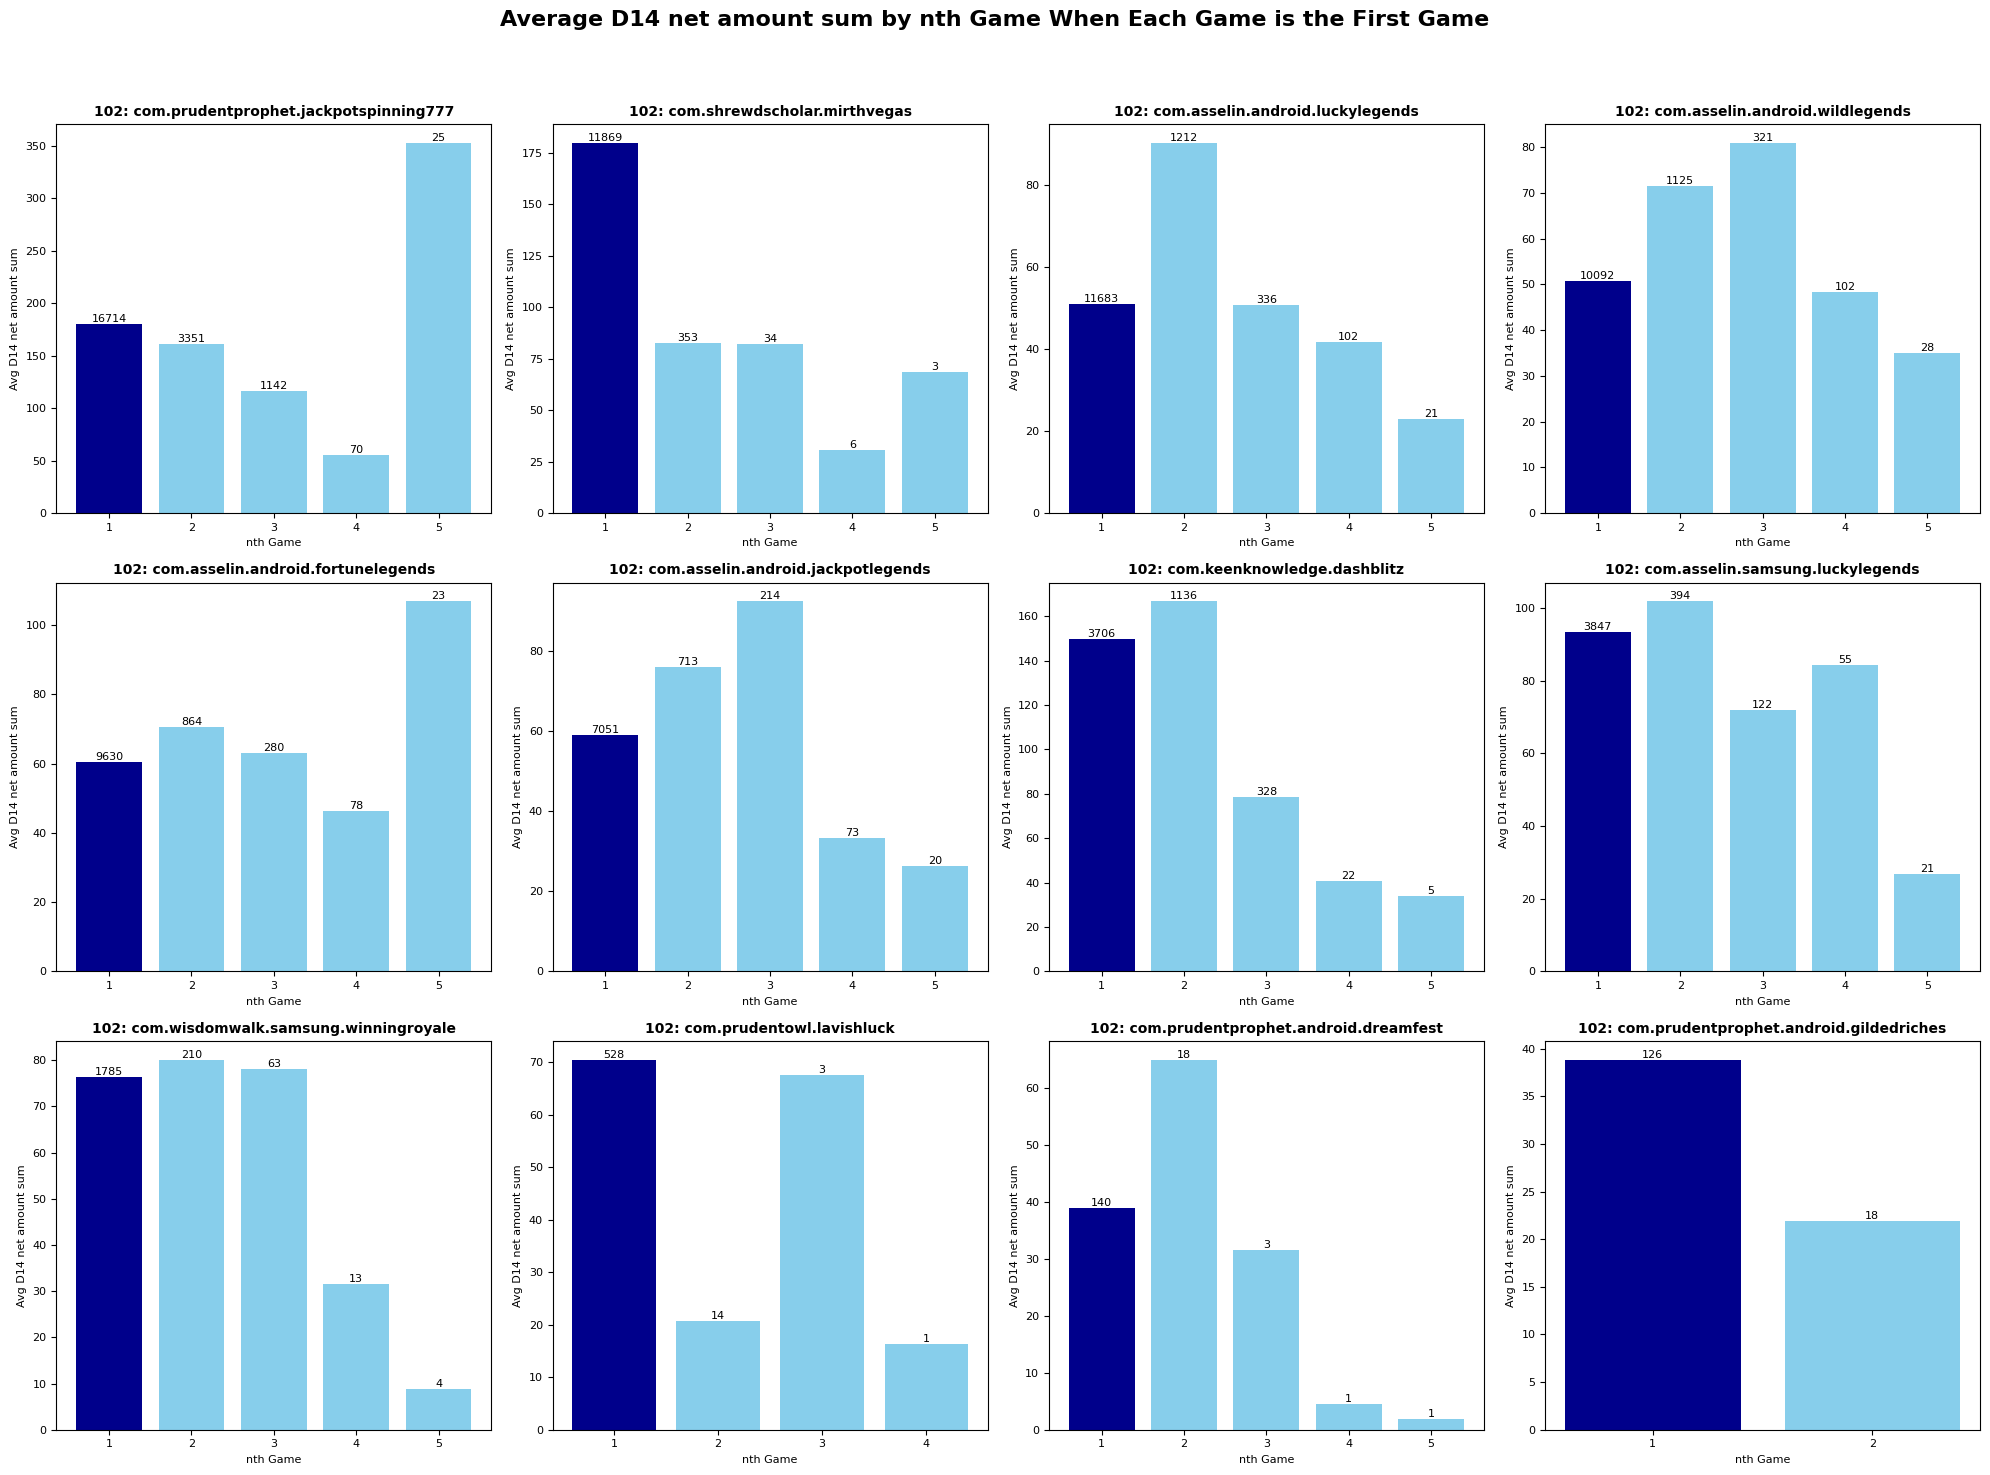

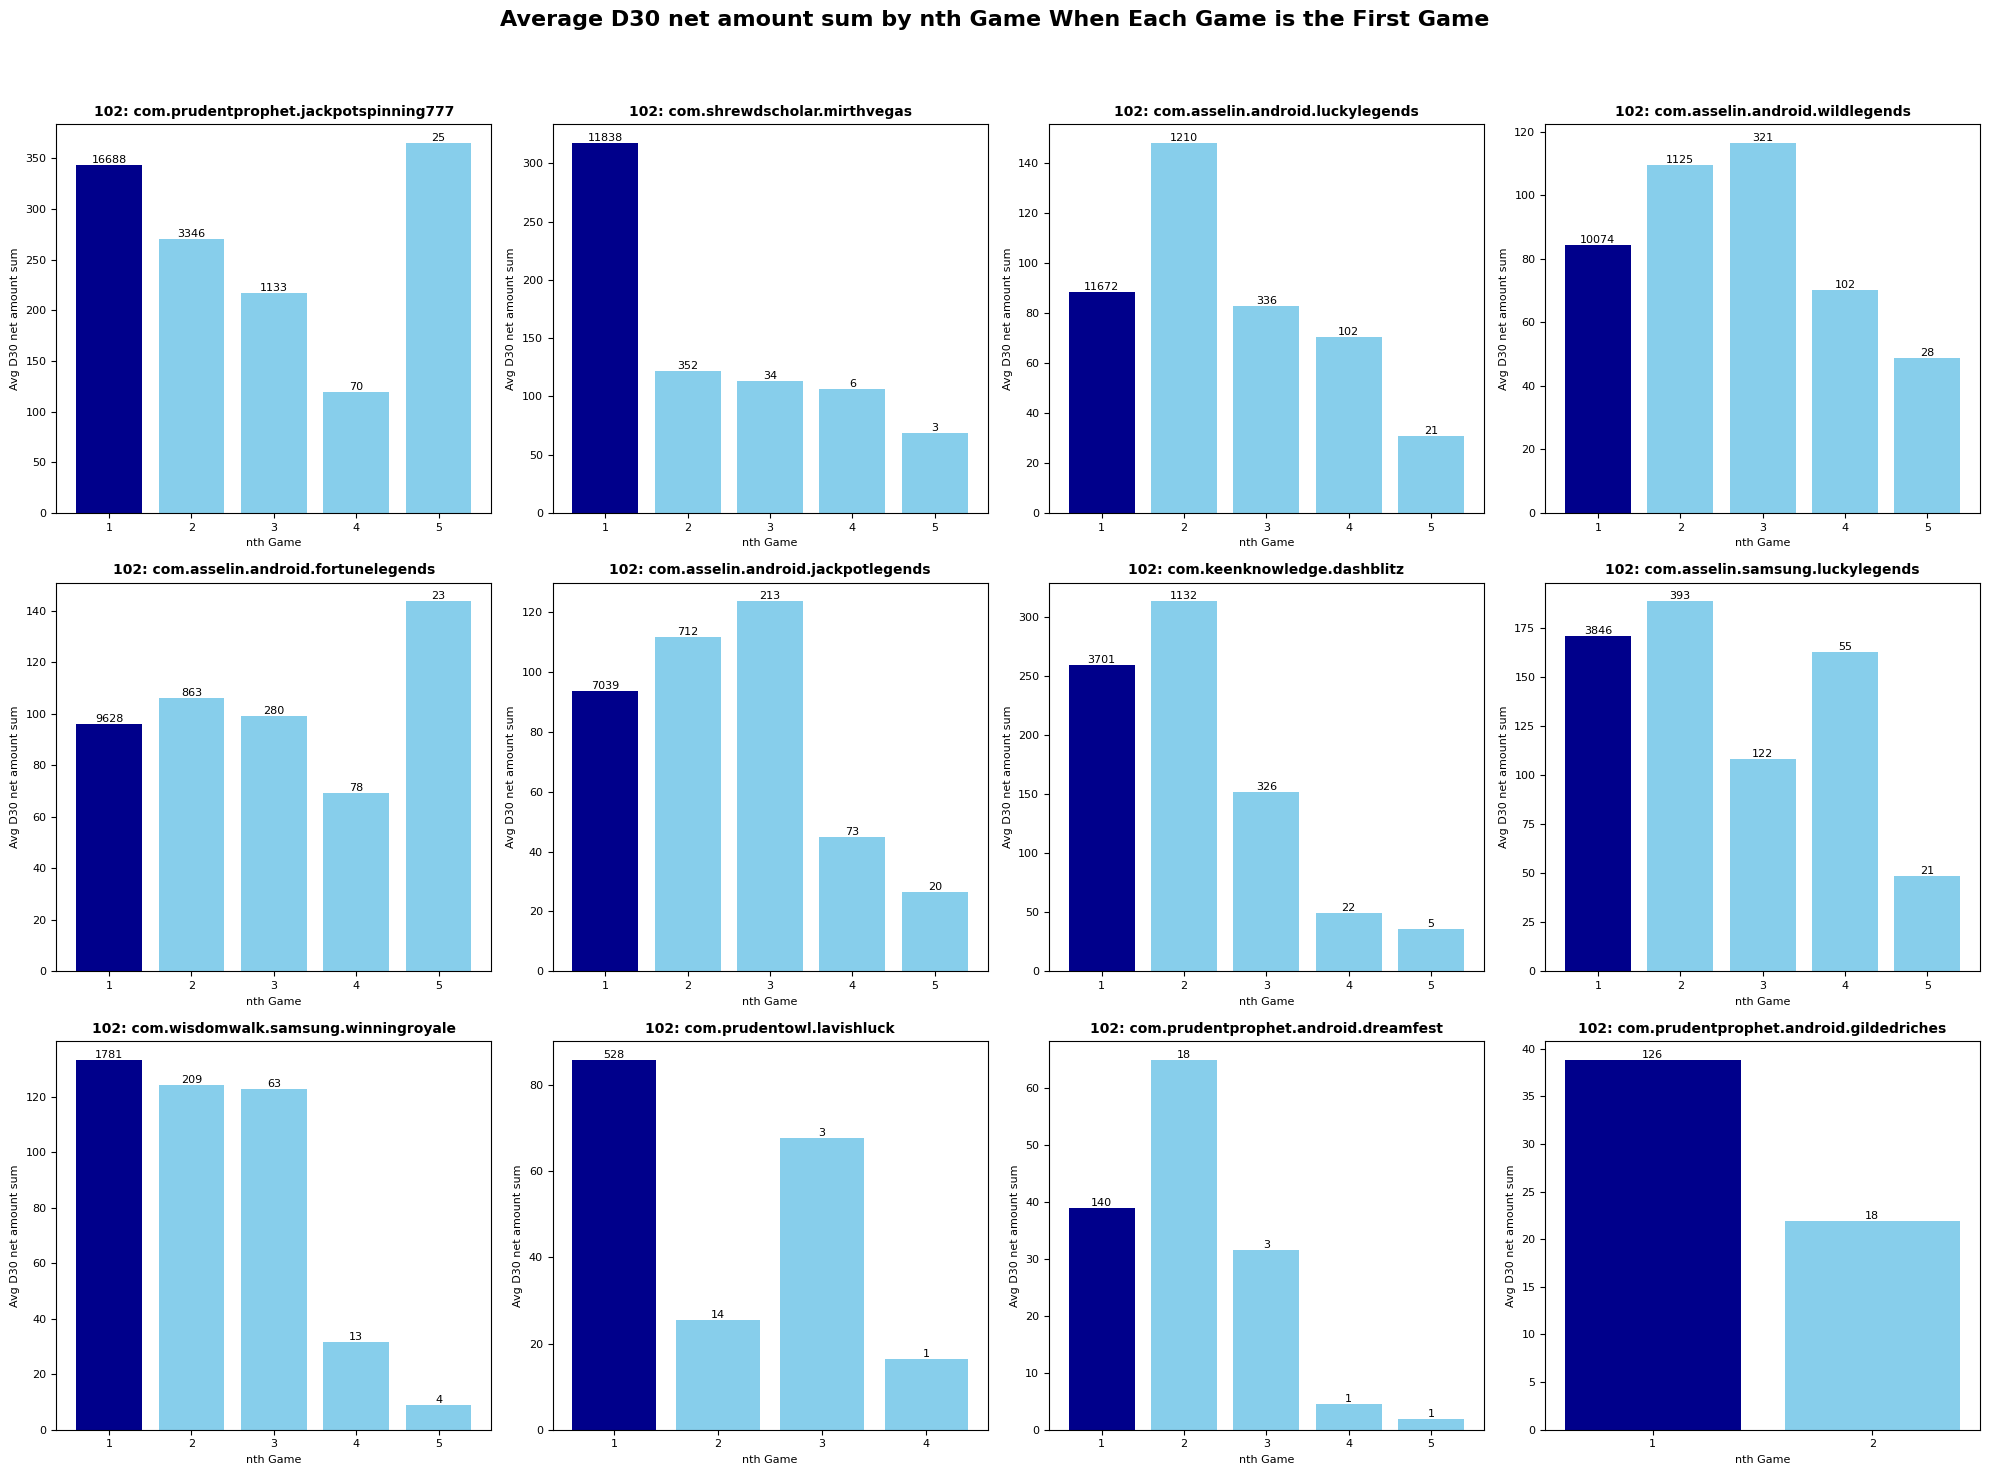

In [ ]:
# Define a list of net amount metrics to iterate over
net_amount_metrics = [
    'd1_net_amount_sum',
    'd3_net_amount_sum',
    'd7_net_amount_sum',
    'd14_net_amount_sum',
    'd30_net_amount_sum'
]
# Iterate through each metric and generate a multi-plot visualization with user counts as labels
for metric in net_amount_metrics:
    # Prepare for storing results for each game's scenario
    result_data = []

    # Iterate over each game and calculate the average of the current metric for subsequent games
    for game in top_games_list:
        # Filter for users where the current game is the first game played
        user_emails_first_game = first_game_data[first_game_data['game'] == game]['email']
        
        # Filter the full dataset for these users
        user_data = df[df['email'].isin(user_emails_first_game)]
        
        # Group by nth_game to calculate the average of the current metric and user counts
        aggregated = (
            user_data.groupby('nth_game')[metric]
            .agg(['mean', 'count'])  # Calculate mean and count
            .reset_index()
            .sort_values(by='nth_game')
        )
        aggregated['game'] = game  # Add game name for context
        result_data.append(aggregated)

    # Combine all results into a single DataFrame
    plot_data = pd.concat(result_data, ignore_index=True)

    # Multi-plot visualization for the current metric
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(
        f"Average {metric.replace('_', ' ').capitalize()} by nth Game When Each Game is the First Game",
        fontsize=16,
        weight='bold'
    )

    # Iterate over each game to create individual plots
    for (game, ax) in zip(top_games_list, axes.flatten()):
        # Filter data for the current game scenario
        game_data = plot_data[plot_data['game'] == game]
        
        # Highlight the first bar
        colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]
        
        # Plot the data
        bars = ax.bar(game_data['nth_game'], game_data['mean'], color=colors)
        
        # Add user count labels to each bar
        for bar, count in zip(bars, game_data['count']):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{count}",
                ha='center',
                va='bottom',
                fontsize=8
            )
        
        # Set titles and labels
        ax.set_title(game, fontsize=10, weight='bold')
        ax.set_xlabel("nth Game", fontsize=8)
        ax.set_ylabel(f"Avg {metric.replace('_', ' ').capitalize()}", fontsize=8)
        ax.set_xticks(game_data['nth_game'])
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Adjust layout and spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



# Analysis 3

Include GMT, include others into the game, 

In [ ]:
import matplotlib.pyplot as plt

# Extracting relevant columns for GGR calculation
timeframes = ['d1', 'd3', 'd7', 'd14', 'd30']

# Calculate GGR for each timeframe
for timeframe in timeframes:
    bet_col = f'{timeframe}_money_bet'
    win_col = f'{timeframe}_money_won'
    df[timeframe + '_ggr'] = df[bet_col] - df[win_col]

    pay_col = f'{timeframe}_net_amount_sum'
    with_col = f'{timeframe}_withdrawn_amount'
    df[timeframe + '_ltv'] = df[pay_col] - df[with_col]
    
    df[timeframe + '_is_payer'] = (df[f'{timeframe}_net_amount_sum'] > 0).astype(int)


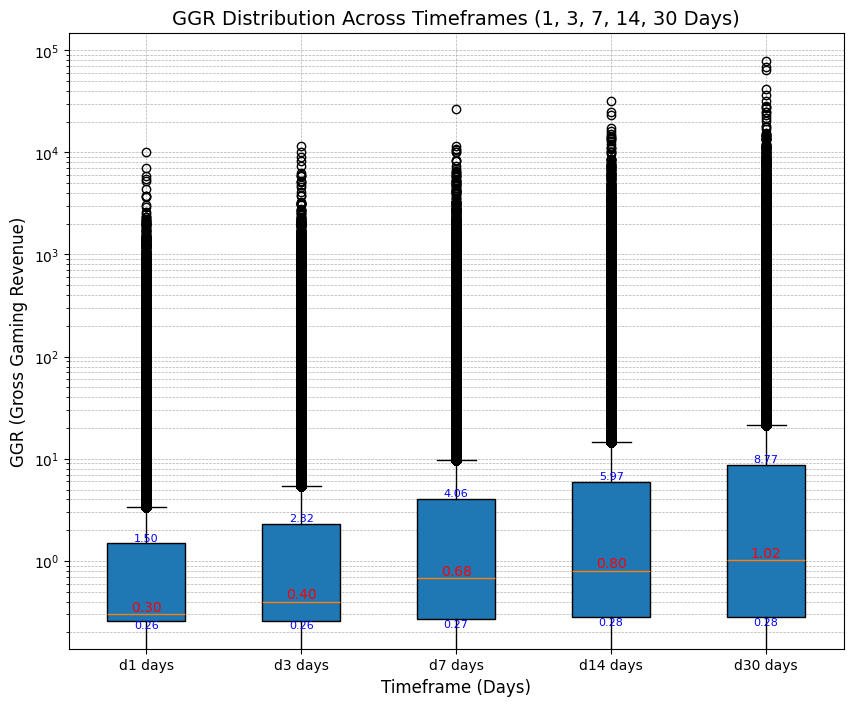

In [33]:
# Plot the boxplot with annotations for median and quartiles
ggr_df = df[[col for col in list(df.columns) if 'ggr' in col]]

# Calculate quartiles and medians for annotation
quartile_data = ggr_df.describe().T[['25%', '50%', '75%']]
positions = range(1, len(timeframes) + 1)  # X-axis positions

plt.figure(figsize=(10, 8))
boxprops = plt.boxplot(ggr_df, patch_artist=True, showmeans=False, vert=True, labels=[f"{d} days" for d in timeframes])

# Adding labels for median and quartiles
for pos, (d, stats) in zip(positions, quartile_data.iterrows()):
    # Annotate median (50%)
    plt.text(pos, stats['50%'], f'{stats["50%"]:.2f}', 
             horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')
    # Annotate Q1 (25%)
    plt.text(pos, stats['25%'], f'{stats["25%"]:.2f}', 
             horizontalalignment='center', verticalalignment='top', fontsize=8, color='blue')
    # Annotate Q3 (75%)
    plt.text(pos, stats['75%'], f'{stats["75%"]:.2f}', 
             horizontalalignment='center', verticalalignment='bottom', fontsize=8, color='blue')

plt.title("GGR Distribution Across Timeframes (1, 3, 7, 14, 30 Days)", fontsize=14)
plt.ylabel("GGR (Gross Gaming Revenue)", fontsize=12)
plt.xlabel("Timeframe (Days)", fontsize=12)
plt.yscale('log')  # Scientific scale for better visualization
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()



In [55]:
df.columns

Index(['#account_id', 'd14_freq', 'd14_money_bet', 'd14_money_won',
       'd14_net_amount_sum', 'd14_withdrawn_amount', 'd1_freq', 'd1_money_bet',
       'd1_money_won', 'd1_net_amount_sum', 'd1_withdrawn_amount', 'd30_freq',
       'd30_money_bet', 'd30_money_won', 'd30_net_amount_sum',
       'd30_withdrawn_amount', 'd3_freq', 'd3_money_bet', 'd3_money_won',
       'd3_net_amount_sum', 'd3_withdrawn_amount', 'd7_freq', 'd7_money_bet',
       'd7_money_won', 'd7_net_amount_sum', 'd7_withdrawn_amount', 'email',
       'game', 'nth_game', 'register_time', 'd1_withdraw_ratio',
       'd3_withdraw_ratio', 'd7_withdraw_ratio', 'd14_withdraw_ratio',
       'd30_withdraw_ratio'],
      dtype='object')

In [ ]:
ggr_d14
freq_d7
d3_money_bet
d14_net_amount_sum

Now you have everything you need to calculate all at once

for metric in metrics
    for day in days 
        for PerPective in PerPective: 
            for case in (binary, multinomial)

            do the multiPle games visual 

In [224]:
grouped_counts = df.groupby(['game', 'nth_game']).size().reset_index(name='count')
grouped_counts

,game,nth_game,count
0,102: com.asselin.android.fortunelegends,1,39511
1,102: com.asselin.android.fortunelegends,2,4230
2,102: com.asselin.android.fortunelegends,3,882
3,102: com.asselin.android.fortunelegends,4,174
4,102: com.asselin.android.fortunelegends,5,16
...,...,...,...
58,102: com.wisdomwalk.samsung.winningroyale,1,6763
59,102: com.wisdomwalk.samsung.winningroyale,2,1517
60,102: com.wisdomwalk.samsung.winningroyale,3,412
61,102: com.wisdomwalk.samsung.winningroyale,4,118


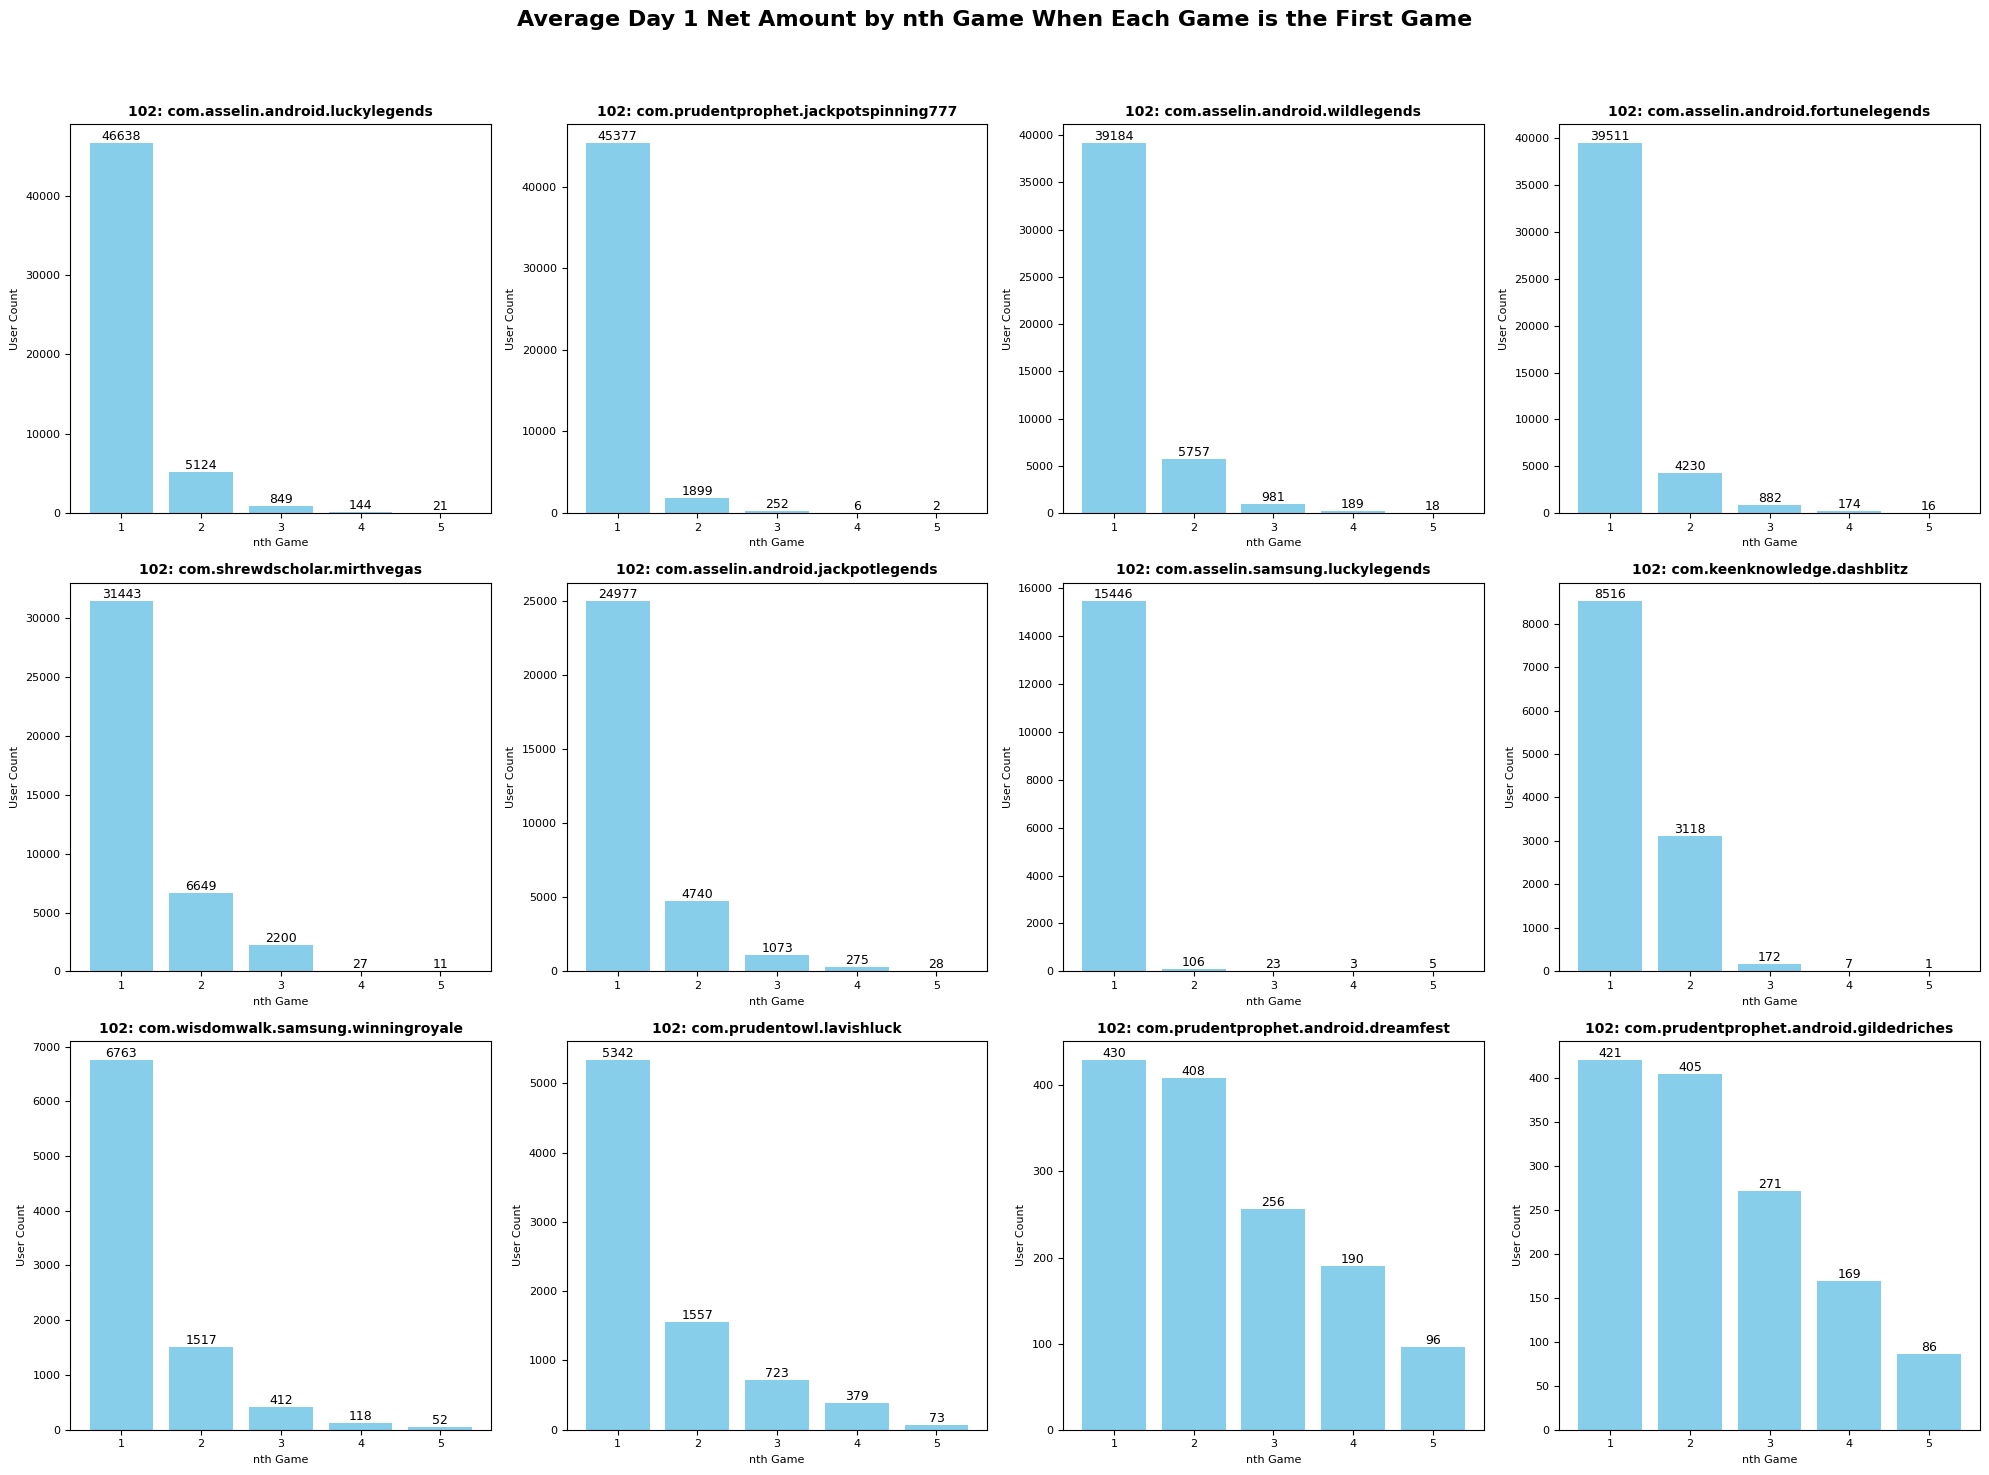

In [225]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `grouped_counts` is already available
# Sum the count for each game across all nth_game values to identify the top 12 games
top_games = grouped_counts.groupby('game')['count'].sum().sort_values(ascending=False).head(12).index

# Filter the grouped_counts dataframe to include only the top 12 games
top_games_data = grouped_counts[grouped_counts['game'].isin(top_games)]

# Create the plot
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Average Day 1 Net Amount by nth Game When Each Game is the First Game', fontsize=16, weight='bold')

for (game, ax) in zip(top_games, axes.flatten()):
    game_data = top_games_data[top_games_data['game'] == game]

    bars = ax.bar(game_data['nth_game'], game_data['count'], color='skyblue')

    # Add the count value above each bar
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{int(bar.get_height())}",  # Display the count as an integer
            ha='center',
            va='bottom',
            fontsize=9
        )

    ax.set_title(game, fontsize=10, weight='bold')
    ax.set_xlabel("nth Game", fontsize=8)
    ax.set_ylabel("User Count", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:

def plot_till_charts_original(df, first_game_data, top_games_list, metric):

    result_data = []

    for game in top_games_list:
        # Filter users where the current game is the first game played
        user_emails_first_game = first_game_data[first_game_data['game'] == game]['email']
        user_data = df[df['email'].isin(user_emails_first_game)]

        # Group by nth_game and calculate average and user counts for the metric
        aggregated = (
            user_data.groupby('nth_game')[metric]
            .agg(['mean', 'count'])
            .reset_index()
            .sort_values(by='nth_game')
        )
        aggregated['game'] = game
        result_data.append(aggregated)

    # Combine results into a single DataFrame
    plot_data = pd.concat(result_data, ignore_index=True)

    # Create multi-plot visualization
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(
        f"Average {metric.replace('_', ' ').capitalize()} by nth Game When Each Game is the First Game",
        fontsize=16, weight='bold'
    )

    for (game, ax) in zip(top_games_list, axes.flatten()):
        game_data = plot_data[plot_data['game'] == game]
        colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]
        bars = ax.bar(game_data['nth_game'], game_data['mean'], color=colors)

        # Add user count labels
        for bar, count in zip(bars, game_data['count']):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{count}",
                ha='center',
                va='bottom',
                fontsize=8
            )

        ax.set_title(game, fontsize=10, weight='bold')
        ax.set_xlabel("nth Game", fontsize=8)
        ax.set_ylabel(f"Avg {metric.replace('_', ' ').capitalize()}", fontsize=8)
        ax.set_xticks(game_data['nth_game'])
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_till_charts(df, first_game_data, top_games_list, metric, case):
    """
    Plots charts showing the average of a metric by game progression. 
    The case argument decides whether to use 'Recycled users'/'New user' or 'nth_game' for the X-axis.

    Parameters:
    - df (DataFrame): The dataset containing user data.
    - first_game_data (DataFrame): The dataset containing information on the first game played by users.
    - top_games_list (list): A list of top games to include in the plot.
    - metric (str): The column name for the metric to be plotted.
    - case (str): 'binary' for Recycled users/New user plot, 'multinomial' for nth_game plot.

    Returns:
    - None: Displays the plots.
    """

    result_data = []

    for game in top_games_list:
        # Filter users where the current game is the first game played
        user_emails_first_game = first_game_data[first_game_data['game'] == game]['email']
        user_data = df[df['email'].isin(user_emails_first_game)]

        # Group by nth_game and calculate average and user counts for the metric
        aggregated = (
            user_data.groupby('nth_game')[metric]
            .agg(['mean', 'count'])
            .reset_index()
            .sort_values(by='nth_game')
        )
        aggregated['game'] = game
        result_data.append(aggregated)

    # Combine results into a single DataFrame
    plot_data = pd.concat(result_data, ignore_index=True)

    # Create multi-plot visualization
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(
        f"Average {metric.replace('_', ' ').capitalize()} by nth Game When Each Game is the First Game",
        fontsize=16, weight='bold'
    )

    for (game, ax) in zip(top_games_list, axes.flatten()):
        game_data = plot_data[plot_data['game'] == game]

        if case == 'binary':
            # For binary case: categorize users as 'Won't play others' (nth_game == 1) or 'Will play others' (nth_game > 1)
            game_data['user_group'] = game_data['nth_game'].apply(
                lambda x: "Won't play others" if x == 1 else "Will play others"
            )
            x_col = 'user_group'
            colors = ['black' if x == "Won't play others" else 'grey' for x in game_data[x_col]]
        else:  # case == 'multinomial'
            # For multinomial case: Use nth_game as the X-axis
            x_col = 'nth_game'
            colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]

        # Create bars for the plot
        bars = ax.bar(game_data[x_col], game_data['mean'], color=colors)

        # Add the associated Y values (mean values) on top of each bar
        for bar, mean in zip(bars, game_data['mean']):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{mean:.2f}",  # Display mean with 2 decimal places
                ha='center',
                va='bottom',
                fontsize=8
            )

        ax.set_title(game, fontsize=10, weight='bold')
        ax.set_xlabel("User Type" if case == 'binary' else "nth Game", fontsize=8)
        ax.set_ylabel(f"Avg {metric.replace('_', ' ').capitalize()}", fontsize=8)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_from_charts(df, top_games_list, metric, case):
    """
    Filter data, preprocess it, and plot McKinsey-style bar charts for New vs Recycled users or nth_game.

    Parameters:
    - df (DataFrame): Original dataset containing game data.
    - top_games_list (list): A list of top games to include in the plot.
    - metric (str): The column name for the metric to be plotted.
    - case (str): 'binary' for 'Recycled user'/'New user', 'multinomial' for nth_game as X-axis.

    Returns:
    - None: Displays the plots.
    """

    # Filter the dataset to include only these top games
    top_games_data = df[df['game'].isin(top_games_list)]
    
    if case == 'binary':
        # Add a 'Treatment' column based on nth_game
        top_games_data['Treatment'] = top_games_data['nth_game'].apply(
            lambda x: 'Recycled user' if x > 1 else 'New user'
        )

        # Group by game and Treatment
        grouped_data = (
            top_games_data.groupby(['game', 'Treatment'])[metric]
            .mean()
            .reset_index()
        )
        x_col = 'Treatment'  # X-axis label for binary case

    else:  # case == 'multinomial'
        # Group by game and nth_game
        grouped_data = (
            top_games_data.groupby(['game', 'nth_game'])[metric]
            .mean()
            .reset_index()
        )
        x_col = 'nth_game'  # X-axis label for multinomial case

    # Ensure games are sorted by their occurrence count for consistency
    grouped_data['game'] = pd.Categorical(
        grouped_data['game'],
        categories=top_games_list,
        ordered=True
    )

    # Plotting McKinsey-style charts for the specified metric
    plt.figure(figsize=(22, 14))
    
    for i, game in enumerate(top_games_list, start=1):
        subset = grouped_data[grouped_data['game'] == game]

        # For binary, calculate percentage difference
        if case == 'binary':
            new_user_value = subset[subset[x_col] == 'New user'][metric].values[0]
            recycled_user_value = subset[subset[x_col] == 'Recycled user'][metric].values[0]
            percentage_diff = ((recycled_user_value - new_user_value) / new_user_value) * 100

            # Color logic for binary case
            bar_colors = ['black' if x == 'New user' else 'grey' for x in subset[x_col]]

        # Set up subplot
        plt.subplot(3, 4, i)

        # Color logic for multinomial case (black for nth_game == 1, grey for others)
        if case == 'multinomial':
            bar_colors = [
                'black' if nth_game == 1 else 'grey' for nth_game in subset[x_col]
            ]
        
        bars = plt.bar(subset[x_col], subset[metric], color=bar_colors, width=0.6)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
        
        # Title with percentage difference (only for binary case)
        if case == 'binary':
            diff_color = 'green' if percentage_diff > 0 else 'red'
            plt.title(
                f'{game}\n% Difference: {percentage_diff:.1f}%', 
                fontsize=12, weight='bold', pad=10, color=diff_color
            )
        else:
            plt.title(game, fontsize=12, weight='bold', pad=10)
        
        # Axes labels
        plt.xlabel('User Type' if case == 'binary' else 'nth_game', fontsize=10)
        plt.ylabel(f'Avg {metric}', fontsize=10)
        
        # Format ticks
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)
        plt.grid(False)

    # Adjust layout for clarity
    plt.suptitle(f'New Users vs Recycled Users: {metric}' if case == 'binary' else f'nth_game Analysis: {metric}', fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_till_charts(df, first_game_data, top_games_list, metric, case):
    """
    Plots charts showing the average of a metric by game progression. 
    The case argument decides whether to use 'Recycled users'/'New user' or 'nth_game' for the X-axis.

    Parameters:
    - df (DataFrame): The dataset containing user data.
    - first_game_data (DataFrame): The dataset containing information on the first game played by users.
    - top_games_list (list): A list of top games to include in the plot.
    - metric (str): The column name for the metric to be plotted.
    - case (str): 'binary' for Recycled users/New user plot, 'multinomial' for nth_game plot.

    Returns:
    - None: Displays the plots.
    """

    result_data = []

    for game in top_games_list:
        # Filter users where the current game is the first game played
        user_emails_first_game = first_game_data[first_game_data['game'] == game]['email']
        user_data = df[df['email'].isin(user_emails_first_game)]

        # Group by nth_game and calculate average and user counts for the metric
        aggregated = (
            user_data.groupby('nth_game')[metric]
            .agg(['mean', 'count'])
            .reset_index()
            .sort_values(by='nth_game')
        )
        aggregated['game'] = game
        result_data.append(aggregated)

    # Combine results into a single DataFrame
    plot_data = pd.concat(result_data, ignore_index=True)

    # Create multi-plot visualization
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(
        f"Average {metric.replace('_', ' ').capitalize()} by nth Game When Each Game is the First Game",
        fontsize=16, weight='bold'
    )

    for (game, ax) in zip(top_games_list, axes.flatten()):
        game_data = plot_data[plot_data['game'] == game]

        if case == 'binary':
            # For binary case: categorize users as 'Won't play others' (nth_game == 1) or 'Will play others' (nth_game > 1)
            game_data['user_group'] = game_data['nth_game'].apply(
                lambda x: "Won't play others" if x == 1 else "Will play others"
            )
            x_col = 'user_group'
            colors = ['black' if x == "Won't play others" else 'grey' for x in game_data[x_col]]
        else:  # case == 'multinomial'
            # For multinomial case: Use nth_game as the X-axis
            x_col = 'nth_game'
            colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]

        # Create bars for the plot
        bars = ax.bar(game_data[x_col], game_data['mean'], color=colors)

        # Add the associated Y values (mean values) on top of each bar
        for bar, mean in zip(bars, game_data['mean']):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{mean:.2f}",  # Display mean with 2 decimal places
                ha='center',
                va='bottom',
                fontsize=8
            )

        ax.set_title(game, fontsize=10, weight='bold')
        ax.set_xlabel("User Type" if case == 'binary' else "nth Game", fontsize=8)
        ax.set_ylabel(f"Avg {metric.replace('_', ' ').capitalize()}", fontsize=8)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_till_charts(df, first_game_data, top_games_list, metric, case):
    """
    Plots charts showing the average of a metric by game progression. 
    The case argument decides whether to use 'Recycled users'/'New user' or 'nth_game' for the X-axis.

    Parameters:
    - df (DataFrame): The dataset containing user data.
    - first_game_data (DataFrame): The dataset containing information on the first game played by users.
    - top_games_list (list): A list of top games to include in the plot.
    - metric (str): The column name for the metric to be plotted.
    - case (str): 'binary' for Recycled users/New user plot, 'multinomial' for nth_game plot.

    Returns:
    - None: Displays the plots.
    """

    # Initialize list to store results
    result_data = []

    for game in top_games_list:
        # Filter users where the current game is the first game played
        user_emails_first_game = first_game_data[first_game_data['game'] == game]['email']
        user_data = df[df['email'].isin(user_emails_first_game)]

        # Group by nth_game and calculate average and user counts for the metric
        aggregated = (
            user_data.groupby('nth_game')[metric]
            .agg(['mean', 'count'])
            .reset_index()
            .sort_values(by='nth_game')
        )
        aggregated['game'] = game
        result_data.append(aggregated)

    # Combine results into a single DataFrame
    plot_data = pd.concat(result_data, ignore_index=True)

    # Create multi-plot visualization
    fig, axes = plt.subplots(3, 4, figsize=(22, 14))
    fig.suptitle(
        f"Average {metric.replace('_', ' ').capitalize()} by nth Game When Each Game is the First Game",
        fontsize=16, weight='bold'
    )

    for (game, ax) in zip(top_games_list, axes.flatten()):
        game_data = plot_data[plot_data['game'] == game]

        if case == 'binary':
            # For binary case: calculate averages directly from the entire df
            # Calculate the average for "Won't play others" (nth_game == 1)
            won_t_play_others_avg = df[df['game'] == game][df['nth_game'] == 1][metric].mean()

            # Calculate the average for "Will play others" (nth_game > 1)
            will_play_others_avg = df[df['game'] == game][df['nth_game'] > 1][metric].mean()
            

            # Prepare data for the X-axis
            x_col = ['Won\'t play others', 'Will play others']
            y_vals = [won_t_play_others_avg, will_play_others_avg]

            colors = ['darkblue', 'skyblue']

        else:  # case == 'multinomial'
            # For multinomial case: Use nth_game as the X-axis
            x_col = 'nth_game'
            colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]
            y_vals = game_data['mean']

        # Create bars for the plot
        bars = ax.bar(x_col if case == 'binary' else game_data[x_col], y_vals, color=colors)

        # Add the associated Y values (mean values) on top of each bar
        for bar, y_val in zip(bars, y_vals):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{y_val:.2f}",  # Display mean with 2 decimal places
                ha='center',
                va='bottom',
                fontsize=8
            )

        ax.set_title(game, fontsize=10, weight='bold')
        ax.set_xlabel("User Type" if case == 'binary' else "nth Game", fontsize=8)
        ax.set_ylabel(f"Avg {metric.replace('_', ' ').capitalize()}", fontsize=8)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
first_game_data = df[df['nth_game'] == 1]
top_games_list = top_games_data['game'].value_counts().head(12).index

metrics = ['ggr', 'ltv', 'withdrawn_amount', 'is_payer', 'net_amount_sum']
timeframes = ['d1', 'd3', 'd7', 'd14', 'd30']
methods = ['from', 'till']
cases = ['binary', 'multinomial']

net_amount_metrics = [
    'd1_net_amount_sum',
    'd3_net_amount_sum',
    'd7_net_amount_sum',
    'd14_net_amount_sum',
    'd30_net_amount_sum'
]

for metric in metrics: 
    print(metric)
    print(type(metric))


    for day in timeframes:
        print(day)

        selected_metric = day + '_' + metric

        for method in methods: 

            print(method)
            
            if method == 'till':
                
                for case in cases: 
                    print(' ')
                    # plot_avg_metrics_by_game(df, first_game_data, top_games_list, selected_metric)
                    plot_till_charts(df, first_game_data, top_games_list, selected_metric, case)
            else:
                for case in cases: 
                    print(' ')
                    plot_from_charts(df, top_games_list, selected_metric, case)


# plot_till_charts and plot_from_charts return Plots, can you store them as images in a zip file?

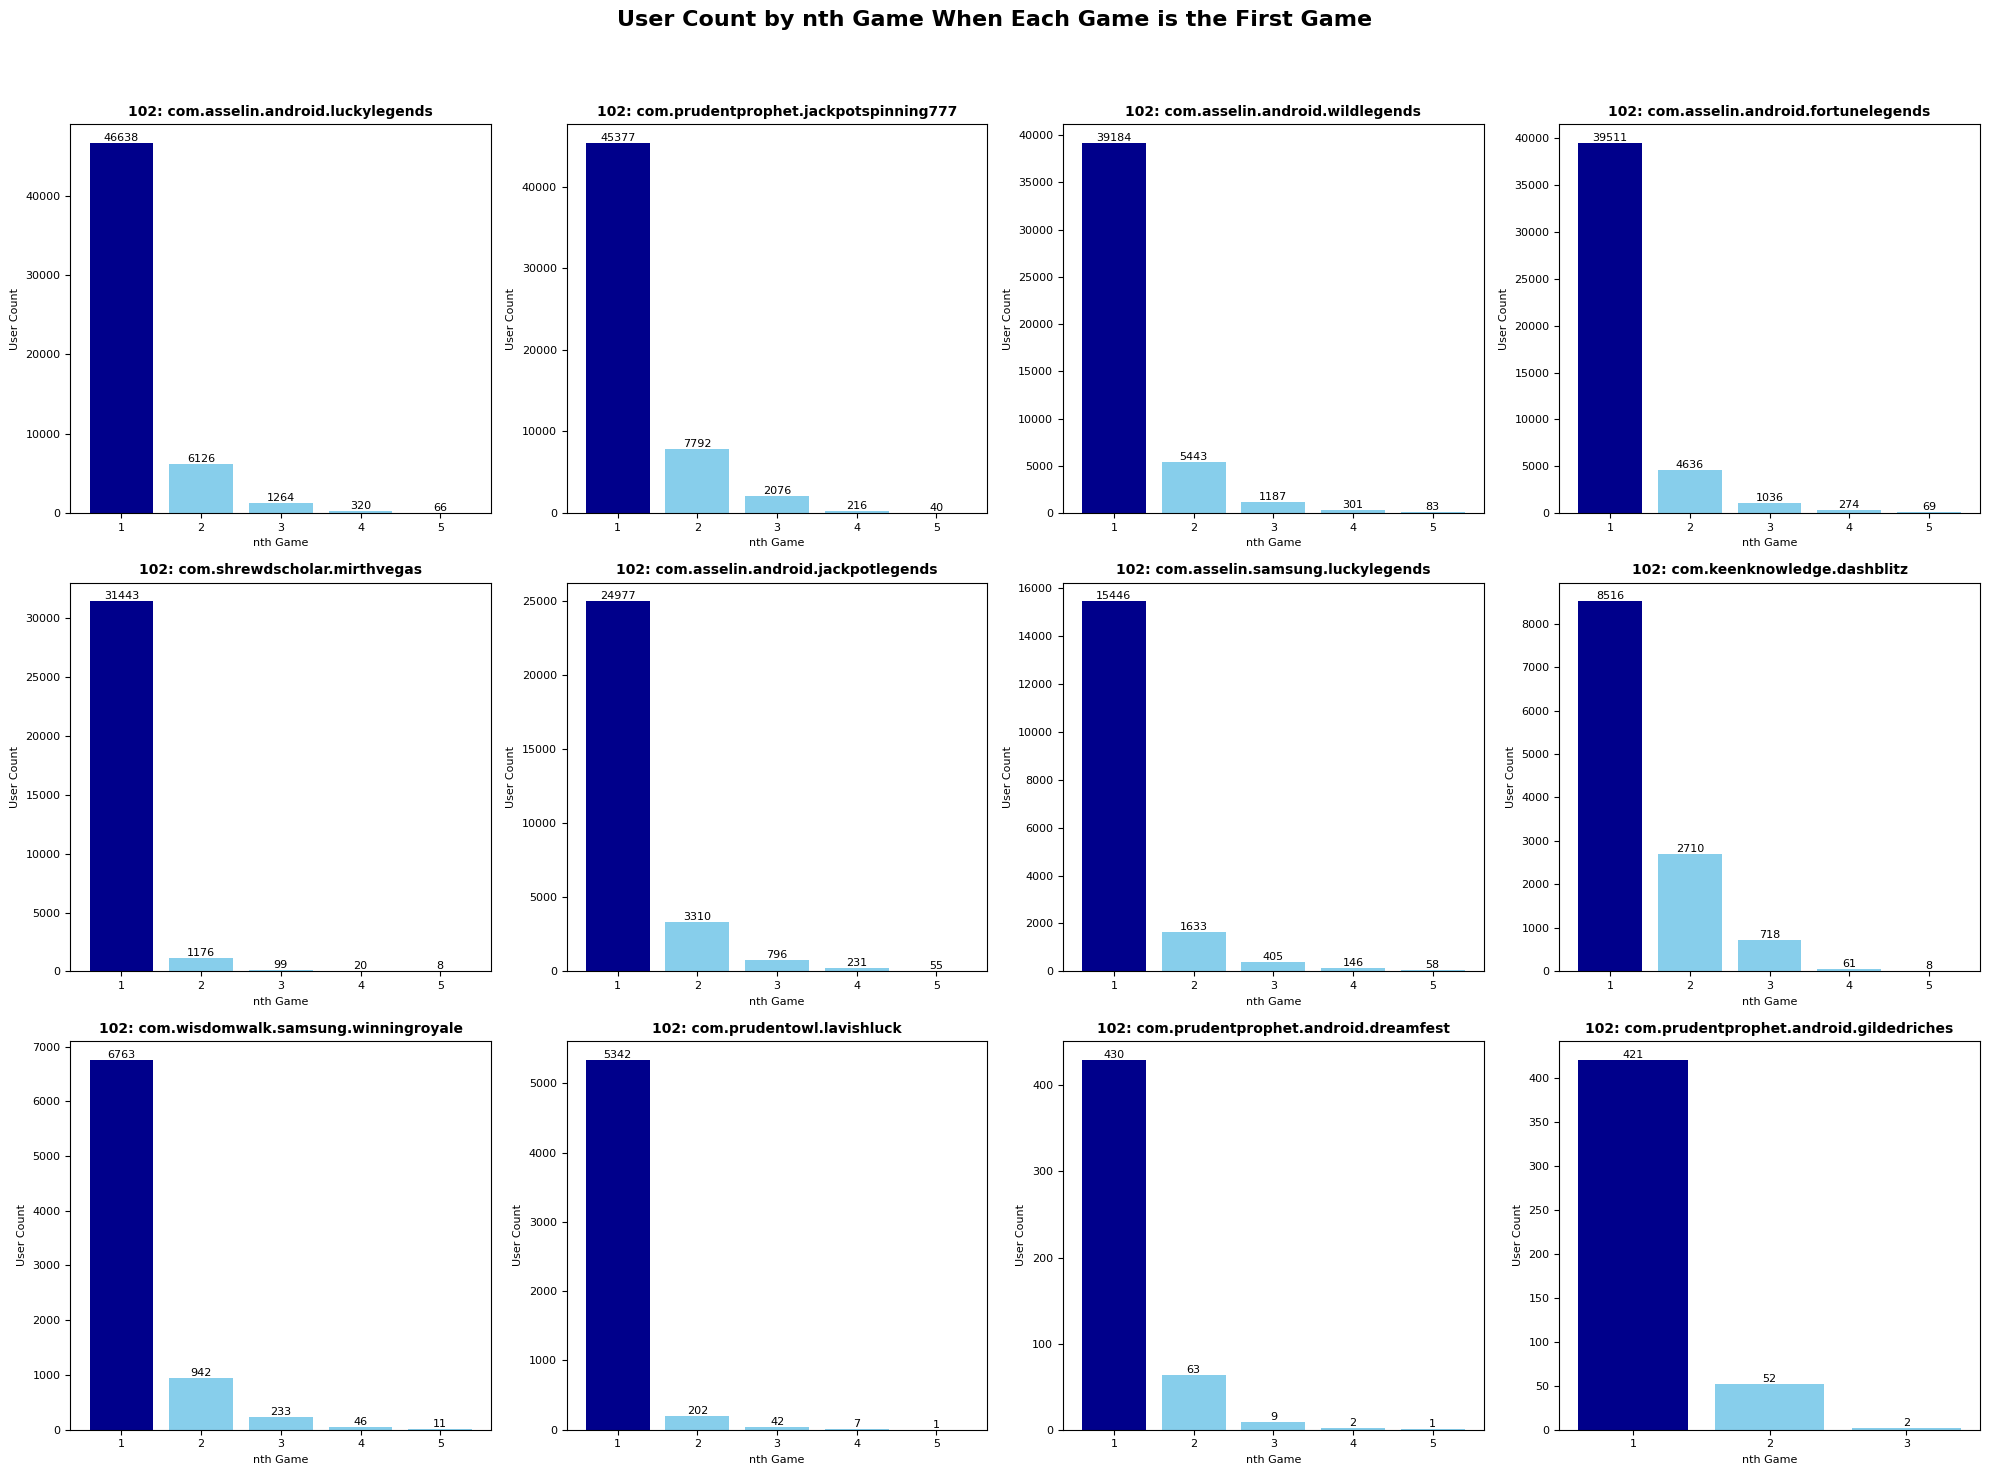

In [230]:

result_data = []
for game in top_games_list:
        # Filter users where the current game is the first game played
        user_emails_first_game = first_game_data[first_game_data['game'] == game]['email']
        user_data = df[df['email'].isin(user_emails_first_game)]

        # Group by nth_game and calculate average and user counts for the metric
        aggregated = (
            user_data.groupby('nth_game')['d1_net_amount_sum']
            .agg(['mean', 'count'])
            .reset_index()
            .sort_values(by='nth_game')
        )
        aggregated['game'] = game
        result_data.append(aggregated)

# Combine results into a single DataFrame
plot_data = pd.concat(result_data, ignore_index=True)


import matplotlib.pyplot as plt

# Assuming the data has already been processed and aggregated

# Create multi-plot visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle(
    "User Count by nth Game When Each Game is the First Game",
    fontsize=16, weight='bold'
)

for (game, ax) in zip(top_games_list, axes.flatten()):
    game_data = plot_data[plot_data['game'] == game]

    # Set colors based on nth_game progression
    colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]
    
    # Plot the user counts (using 'count' instead of 'mean')
    bars = ax.bar(game_data['nth_game'], game_data['count'], color=colors)

    # Add user count labels on top of the bars
    for bar, count in zip(bars, game_data['count']):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{count}",
            ha='center',
            va='bottom',
            fontsize=8
        )

    # Set plot titles and labels
    ax.set_title(game, fontsize=10, weight='bold')
    ax.set_xlabel("nth Game", fontsize=8)
    ax.set_ylabel("User Count", fontsize=8)
    ax.set_xticks(game_data['nth_game'])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
withdrawn_amount

['withdraw_ratio']

### ExPort to ziP

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os

def plot_till_charts(df, first_game_data, top_games_list, metric, case, zipf):
    """
    Plots charts showing the average of a metric by game progression and saves them as images in a ZIP file.

    Parameters:
    - df (DataFrame): The dataset containing user data.
    - first_game_data (DataFrame): The dataset containing information on the first game played by users.
    - top_games_list (list): A list of top games to include in the plot.
    - metric (str): The column name for the metric to be plotted.
    - case (str): 'binary' for Recycled users/New user plot, 'multinomial' for nth_game plot.
    - zipf (ZipFile): The ZIP file object to save the images.
    """
    
    # Initialize list to store results
    result_data = []

    for game in top_games_list:
        user_emails_first_game = first_game_data[first_game_data['game'] == game]['email']
        user_data = df[df['email'].isin(user_emails_first_game)]

        if 'withdraw_ratio' in metric: 
            first_item = metric.split('_')[0] + '_'
            aggregated = (
                user_data.groupby('nth_game')[[first_item + 'net_amount_sum', first_item + 'withdrawn_amount']]
                .agg(['mean'])
                .reset_index())
            aggregated['game'] = game
            aggregated['withdraw_ratio'] = aggregated['withdrawn_amount'] / aggregated['net_amount_sum']
            del aggregated[first_item + 'net_amount_sum']
            del aggregated[first_item + 'withdrawn_amount']
        else:     
            # Group by nth_game and calculate average and user counts for the metric
            aggregated = (
                user_data.groupby('nth_game')[metric]
                .agg(['mean', 'count'])
                .reset_index()
                .sort_values(by='nth_game'))
            aggregated['game'] = game
        
        result_data.append(aggregated)

    # Combine results into a single DataFrame
    plot_data = pd.concat(result_data, ignore_index=True)

    # Create multi-plot visualization
    fig, axes = plt.subplots(3, 4, figsize=(22, 14))
    fig.suptitle(
        f"Average {metric.replace('_', ' ').capitalize()} by nth Game When Each Game is the First Game",
        fontsize=16, weight='bold'
    )

    for (game, ax) in zip(top_games_list, axes.flatten()):
        game_data = plot_data[plot_data['game'] == game]

        if case == 'binary':
            won_t_play_others_avg = df[df['game'] == game][df['nth_game'] == 1][metric].mean()
            will_play_others_avg = df[df['game'] == game][df['nth_game'] > 1][metric].mean()
            x_col = ['Won\'t play others', 'Will play others']
            y_vals = [won_t_play_others_avg, will_play_others_avg]
            colors = ['darkblue', 'skyblue']
        else:  
            x_col = 'nth_game'
            colors = ['darkblue' if nth == 1 else 'skyblue' for nth in game_data['nth_game']]
            y_vals = game_data['mean']

        bars = ax.bar(x_col if case == 'binary' else game_data[x_col], y_vals, color=colors)

        for bar, y_val in zip(bars, y_vals):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{y_val:.2f}",  
                ha='center',
                va='bottom',
                fontsize=8
            )

        ax.set_title(game, fontsize=10, weight='bold')
        ax.set_xlabel("User Type" if case == 'binary' else "nth Game", fontsize=8)
        ax.set_ylabel(f"Avg {metric.replace('_', ' ').capitalize()}", fontsize=8)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save each figure to the ZIP file
    img_name = f'{metric}_{case}_till_charts.png'
    img_path = f'{img_name}'
    plt.savefig(img_path)
    plt.close(fig)
    
    # Add to zip
    zipf.write(img_path, img_name)
    os.remove(img_path)  # Clean up the saved image file



In [ ]:
        # if 'withdrawn_amount' == metric: 
        #     aggregated = (
        #         user_data.groupby('nth_game')[['net_amount_sum', 'withdrawn_amount']]
        #         .agg(['mean'])
        #         .reset_index())
        #     aggregated['game'] = game
        #     aggregated['withdraw_ratio'] = aggregated['withdrawn_amount'] / aggregated['net_amount_sum']
        # else:     
        #     # Group by nth_game and calculate average and user counts for the metric
        #     aggregated = (
        #         user_data.groupby('nth_game')[metric]
        #         .agg(['mean', 'count'])
        #         .reset_index()
        #         .sort_values(by='nth_game'))
        #     aggregated['game'] = game
        
        # result_data.append(aggregated)

In [ ]:
def plot_from_charts(df, top_games_list, metric, case, zipf):
    """
    Filter data, preprocess it, and plot McKinsey-style bar charts for New vs Recycled users or nth_game, and save them as images in a ZIP file.

    Parameters:
    - df (DataFrame): Original dataset containing game data.
    - top_games_list (list): A list of top games to include in the plot.
    - metric (str): The column name for the metric to be plotted.
    - case (str): 'binary' for 'Recycled user'/'New user', 'multinomial' for nth_game as X-axis.
    - zipf (ZipFile): The ZIP file object to save the images.
    """
    
    top_games_data = df[df['game'].isin(top_games_list)]
    
    if case == 'binary':
        top_games_data['Treatment'] = top_games_data['nth_game'].apply(
            lambda x: 'Recycled user' if x > 1 else 'New user'
        )
        grouped_data = (
            top_games_data.groupby(['game', 'Treatment'])[metric]
            .mean()
            .reset_index()
        )
        x_col = 'Treatment'
    else:
        grouped_data = (
            top_games_data.groupby(['game', 'nth_game'])[metric]
            .mean()
            .reset_index()
        )
        x_col = 'nth_game'

    grouped_data['game'] = pd.Categorical(
        grouped_data['game'],
        categories=top_games_list,
        ordered=True
    )

    plt.figure(figsize=(22, 14))
    
    for i, game in enumerate(top_games_list, start=1):
        subset = grouped_data[grouped_data['game'] == game]

        if case == 'binary':
            new_user_value = subset[subset[x_col] == 'New user'][metric].values[0]
            recycled_user_value = subset[subset[x_col] == 'Recycled user'][metric].values[0]
            percentage_diff = ((recycled_user_value - new_user_value) / new_user_value) * 100
            bar_colors = ['black' if x == 'New user' else 'grey' for x in subset[x_col]]
        else:
            bar_colors = ['black' if nth_game == 1 else 'grey' for nth_game in subset[x_col]]

        plt.subplot(3, 4, i)

        bars = plt.bar(subset[x_col], subset[metric], color=bar_colors, width=0.6)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

        if case == 'binary':
            diff_color = 'green' if percentage_diff > 0 else 'red'
            plt.title(
                f'{game}\n% Difference: {percentage_diff:.1f}%', 
                fontsize=12, weight='bold', pad=10, color=diff_color
            )
        else:
            plt.title(game, fontsize=12, weight='bold', pad=10)
        
        plt.xlabel('User Type' if case == 'binary' else 'nth_game', fontsize=10)
        plt.ylabel(f'Avg {metric}', fontsize=10)
        
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)
        plt.grid(False)

    plt.suptitle(f'New Users vs Recycled Users: {metric}' if case == 'binary' else f'nth_game Analysis: {metric}', fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()

    img_name = f'{metric}_{case}_from_charts.png'
    img_path = f'{img_name}'
    plt.savefig(img_path)
    plt.close()

    # Add to zip
    zipf.write(img_path, img_name)
    os.remove(img_path)


In [ ]:
    if case == 'binary':
        top_games_data['Treatment'] = top_games_data['nth_game'].apply(
            lambda x: 'Recycled user' if x > 1 else 'New user'
        )
        grouped_data = (
            top_games_data.groupby(['game', 'Treatment'])[metric]
            .mean()
            .reset_index()
        )
        x_col = 'Treatment'
    else:
        grouped_data = (
            top_games_data.groupby(['game', 'nth_game'])[metric]
            .mean()
            .reset_index()
        )
        x_col = 'nth_game'

    grouped_data['game'] = pd.Categorical(
        grouped_data['game'],
        categories=top_games_list,
        ordered=True
    )

'withdraw_ratio'

In [77]:
def plot_from_charts_withdraw_ratio(df, top_games_list, metric, case, zipf):
    """
    Filter data, preprocess it, and plot McKinsey-style bar charts for New vs Recycled users or nth_game, and save them as images in a ZIP file.

    Parameters:
    - df (DataFrame): Original dataset containing game data.
    - top_games_list (list): A list of top games to include in the plot.
    - metric (str): The column name for the metric to be plotted.
    - case (str): 'binary' for 'Recycled user'/'New user', 'multinomial' for nth_game as X-axis.
    - zipf (ZipFile): The ZIP file object to save the images.
    """
    first_item = metric.split('_')[0] + '_'
    top_games_data = df[df['game'].isin(top_games_list)]
    
    if case == 'binary':
        top_games_data['Treatment'] = top_games_data['nth_game'].apply(
            lambda x: 'Recycled user' if x > 1 else 'New user'
        )
        grouped_data = (
            top_games_data.groupby(['game', 'Treatment'])[[first_item + 'net_amount_sum', first_item + 'withdrawn_amount']]
            .mean()
            .reset_index()
        )
        grouped_data[metric] = grouped_data[first_item + 'withdrawn_amount'] / grouped_data[first_item + 'net_amount_sum']
        del grouped_data[first_item + 'net_amount_sum']
        del grouped_data[first_item + 'withdrawn_amount']

        x_col = 'Treatment'
        print(x_col)

    else:
        grouped_data = (
            top_games_data.groupby(['game', 'nth_game'])[[first_item + 'net_amount_sum', first_item + 'withdrawn_amount']]
            .mean()
            .reset_index()
        )

        grouped_data[metric] = grouped_data[first_item + 'withdrawn_amount'] / grouped_data[first_item + 'net_amount_sum']
        del grouped_data[first_item + 'net_amount_sum']
        del grouped_data[first_item + 'withdrawn_amount']

        x_col = 'nth_game'

    grouped_data['game'] = pd.Categorical(
        grouped_data['game'],
        categories=top_games_list,
        ordered=True
    )

    plt.figure(figsize=(22, 14))
    
    for i, game in enumerate(top_games_list, start=1):
        subset = grouped_data[grouped_data['game'] == game]

        if case == 'binary':
            new_user_value = subset[subset[x_col] == 'New user'][metric].values[0]
            recycled_user_value = subset[subset[x_col] == 'Recycled user'][metric].values[0]
            percentage_diff = ((recycled_user_value - new_user_value) / new_user_value) * 100
            bar_colors = ['black' if x == 'New user' else 'grey' for x in subset[x_col]]
        else:
            bar_colors = ['black' if nth_game == 1 else 'grey' for nth_game in subset[x_col]]

        plt.subplot(3, 4, i)

        bars = plt.bar(subset[x_col], subset[metric], color=bar_colors, width=0.6)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

        if case == 'binary':
            diff_color = 'green' if percentage_diff > 0 else 'red'
            plt.title(
                f'{game}\n% Difference: {percentage_diff:.1f}%', 
                fontsize=12, weight='bold', pad=10, color=diff_color
            )
        else:
            plt.title(game, fontsize=12, weight='bold', pad=10)
        
        plt.xlabel('User Type' if case == 'binary' else 'nth_game', fontsize=10)
        plt.ylabel(f'Avg {metric}', fontsize=10)
        
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)
        plt.grid(False)

    plt.suptitle(f'New Users vs Recycled Users: {metric}' if case == 'binary' else f'nth_game Analysis: {metric}', fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()

    img_name = f'{metric}_{case}_from_charts.png'
    img_path = f'{img_name}'
    plt.savefig(img_path)
    plt.close()

    # Add to zip
    zipf.write(img_path, img_name)
    os.remove(img_path)


In [49]:
metrics = ['withdraw_ratio']
timeframes = ['d7', 'd30']

In [58]:
selected_metric

'd30_withdraw_ratio'

In [78]:
import zipfile

# Create a ZIP file
zip_file_path = 'plots_withdraw_ratios.zip'
with zipfile.ZipFile(zip_file_path, 'w') as zipf:

    # Loop through metrics and timeframes as before
    for metric in metrics:
        print(metric)

        for day in timeframes:
            print(day)

            selected_metric = day + '_' + metric

            for method in methods:
                print(method)

                if method == 'till':
                    for case in cases:
                        print(' ')
                        plot_till_charts(df, first_game_data, top_games_list, selected_metric, case, zipf)
                else:
                    for case in cases:
                        print(' ')
                        plot_from_charts_withdraw_ratio(df, top_games_list, selected_metric, case, zipf)

# The plots will be stored in the ZIP file at 'plots.zip'


withdraw_ratio
d7
from
 
Treatment


C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3267366915.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_games_data['Treatment'] = top_games_data['nth_game'].apply(


 
till
 


C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  won_t_play_others_avg = df[df['game'] == game][df['nth_game'] == 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  will_play_others_avg = df[df['game'] == game][df['nth_game'] > 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  won_t_play_others_avg = df[df['game'] == game][df['nth_game'] == 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  will_play_others_avg = df[df['game'] == game][df['nth_game'] > 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:58: UserWarning: Boolean

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3267366915.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_games_data['Treatment'] = top_games_data['nth_game'].apply(


d30
from
 
Treatment
 
till
 


C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  won_t_play_others_avg = df[df['game'] == game][df['nth_game'] == 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  will_play_others_avg = df[df['game'] == game][df['nth_game'] > 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  won_t_play_others_avg = df[df['game'] == game][df['nth_game'] == 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  will_play_others_avg = df[df['game'] == game][df['nth_game'] > 1][metric].mean()
C:\Users\Win11\AppData\Local\Temp\ipykernel_28488\3143780521.py:58: UserWarning: Boolean

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
